In [1]:
#| default_exp aa_mixer_toy

# aa_mixer_toy

> Toy model of the "straightening" of the aa-mixer model

We stick an autoencoder in the middle of some embedding system, designed to preserve linearity in the middle of the autoencoder.

In [ ]:
# install a few non-standard dependencies
%pip install einops tqdm wandb 

In [199]:
#| export
import math
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import string
import numpy as np

import torch
from torch import optim, nn, Tensor
from torch.nn import functional as F
from torch.utils import data as torchdata

from einops import rearrange
from tqdm.auto import tqdm
import wandb

Get/set a few "environment" related variables

In [53]:
#|export 
def get_device(gpu_str=''):
    #return torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
    device_str = 'cpu'
    if torch.cuda.is_available():
        device_str = 'cuda' if gpu_str=='' else f'cuda:{gpu_str}'
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available(): # must check for mps attr if using older pytorch
        device_str = 'mps'
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
    return torch.device(device_str)

device = get_device()
print("device = ",device)

    
SCRATCH_DIR = "/scratch" if os.path.isdir('/scratch') else "/tmp"
SCRATCH_DIR += '/aa'  # give audio alg scratch its own spot
if not os.path.exists(SCRATCH_DIR):
    os.makedirs(SCRATCH_DIR)
print("SCRATCH_DIR =",SCRATCH_DIR)

device =  cuda
SCRATCH_DIR = /tmp/aa


In [3]:
# generate a unique 2-character code for the run
suffix_len = 2
RUN_SUFFIX = '_'+''.join(random.choices(string.ascii_lowercase, k=suffix_len))
print("RUN_SUFFIX =",RUN_SUFFIX)

device =  cuda
SCRATCH_DIR = /tmp/aa
RUN_SUFFIX = _vm


## Make up some data
For starters, just a bunch of random numbers

In [4]:
seed = 5   
torch.manual_seed(seed)
batch_size = 1024
n_train_points, train_val_split  = batch_size*2000,  0.8 # we're going to grab random data anyway
n_points = int(n_train_points*1.25) 
in_dims = 2 # number of dimensions the input data will live in, e.g. 2 or 3
emb_dims = 2 # number of dimensions for embeddings 

train_val_split = 0.8 
train_len, val_len = round(n_points*train_val_split), round(n_points*(1-train_val_split))

class RandVecDataset(torchdata.Dataset):
    "very simple dataset"
    def __init__(self, length, dims):
        super().__init__()
        self.data = 2*torch.rand(length, dims) - 1 
        
    def __getitem__(self, idx):
        return self.data[idx]                                               
        
    def __len__(self): 
         return self.data.shape[0]  
                                                        
train_dataset = RandVecDataset(train_len, in_dims)
val_dataset = RandVecDataset(val_len, in_dims)
v = train_dataset.__getitem__(0)
print(train_dataset.__len__(), v.shape)
print(val_dataset.__len__(), v.shape)


2048000 torch.Size([2])
512000 torch.Size([2])


In [5]:
train_dl = torchdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = torchdata.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
val_iter = iter(val_dl)

**DEMO BATCH**: Vizualization demo batch (same each time)

In [6]:
#| export
def get_demo_batch(val_iter, 
                   demo_line = True, 
                   debug=False):
    demo_batch = next(val_iter).clone()
    absmax = (torch.abs(demo_batch)).max().item()

    if demo_line:  # make demo batch lie along a line in order to showcase nonlinearity
        demo_batch[:,1] = demo_batch[:,0]  # line y = x
        demo_batch[::2,0] *= -1            # even-numbered points go to y = -x
        demo_batch[::4,0] = 0.01   # data along y axis
        demo_batch[1::4,1] = 0.01  # data along x axis
        demo_batch[::5] = absmax*(2*torch.rand((demo_batch[::5]).shape)-1)   # make some points random
        demo_batch[1::7] = absmax*(2*torch.rand((demo_batch[1::7]).shape)-1)  # and more points random
    return demo_batch

Text(0.5, 1.0, 'mix of "lines+dots" + unit noise')

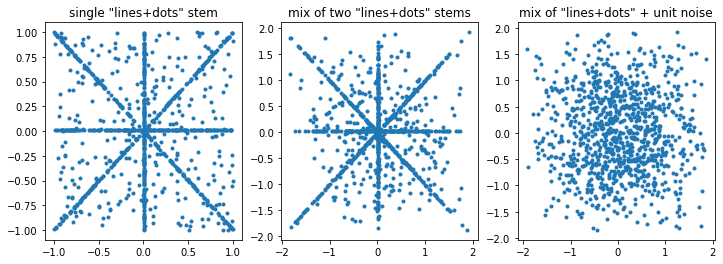

In [7]:
# plot what the demo batch looks like in input space -- you're going to be seeing this alot!
fig, ax = plt.subplots(1,3, figsize=(12,4))

demo_batch = get_demo_batch(val_iter, debug=True)
ax[0].plot(demo_batch[:,0], demo_batch[:,1], marker='.', linestyle='None')
ax[0].set_title('single "lines+dots" stem')
print("")

demo_mix = demo_batch + get_demo_batch(val_iter, demo_line=True, debug=True) # add another 'line stem'
ax[1].plot(demo_mix[:,0], demo_mix[:,1], marker='.', linestyle='None')
ax[1].set_title('mix of two "lines+dots" stems')

demo_mix = demo_batch + get_demo_batch(val_iter, demo_line=False, debug=True) # random noise will swamp lines
ax[2].plot(demo_mix[:,0], demo_mix[:,1], marker='.', linestyle='None')
ax[2].set_title('mix of "lines+dots" + unit noise')

...so in general our mix of random numbers -- even if one of the stems has a nice pattern -- will just be a bunch of random numbers. 

We'll use the far right for "demo_mix" since that's what it'll typically look like, whereas the middle graph is contrived. 

## Generic Building Blocks


In [8]:
#| export 
class EmbedBlock(nn.Module):
    def __init__(self, in_dims:int, out_dims:int, act=nn.GELU(), resid=True, use_bn=False, requires_grad=True, **kwargs) -> None:
        "generic little block for embedding stuff.  note residual-or-not doesn't seem to make a huge difference for a-a"
        super().__init__()
        self.in_dims, self.out_dims, self.act, self.resid = in_dims, out_dims, act, resid
        self.lin = nn.Linear(in_dims, out_dims, **kwargs)
        self.bn = nn.BatchNorm1d(out_dims) if use_bn else None # even though points in 2d, only one non-batch dim in data

        if requires_grad == False:
            self.lin.weight.requires_grad = False
            self.lin.bias.requires_grad = False

    def forward(self, xin: Tensor) -> Tensor:
        x = self.lin(xin)
        if self.act is not None: x = self.act(x)
        if self.bn is not None: x = self.bn(x)   # re. "BN before or after Activation? cf. https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md"
        return xin + x if (self.resid and self.in_dims==self.out_dims) else x 

In [9]:
# test that
emb_test = EmbedBlock(2, 2, use_bn=True, requires_grad=False)
#res_test = ResBlock(2, 2)

## The Given (Auto)Encoder
This is a stand-in for whatever the main encoder is to be, 
i.e. for which the audio-algebra is going be inserted in the middle of.  
This could be an actual audio encoder or,...just something random.

Now, for word embeddings these are typically just weights from a linear transformation, but we're going to assume that there's maybe some set of nonlinear tranformations that led us to this point. 

### Two choices:
1. Some randomly-initialized neural network
2. A nonlinear compress-and-twist model

In [10]:
#|export   
class SimpleAutoEncoder(nn.Module):
    """for now just something random with a bit of nonlinearity
    """
    def __init__(self, 
        in_dims=2,        # number of input dimensions to use
        hidden_dims=32,   # number of hidden dimensions
        emb_dims=2,       # number of output dimensions to use
        frozen_enc=False,   # don't let the encoder weights evolve
        act=nn.GELU(),  # activation function(s) to use
        ): 
        super().__init__()
        self.encoder = nn.Sequential(  
            #EmbedBlock(in_dims, emb_dims),
            EmbedBlock(in_dims, hidden_dims, act=act, requires_grad=not frozen_enc),
            EmbedBlock(hidden_dims, hidden_dims, act=act, requires_grad=not frozen_enc),
            EmbedBlock(hidden_dims, hidden_dims, act=act, requires_grad=not frozen_enc),
            nn.Linear(hidden_dims, emb_dims),
        )
        self.decoder = nn.Sequential(  
            #EmbedBlock(emb_dims, in_dims),
            EmbedBlock(emb_dims, hidden_dims, act=act),
            EmbedBlock(hidden_dims, hidden_dims, act=act),   
            EmbedBlock(hidden_dims, hidden_dims, act=act),            
            nn.Linear(hidden_dims, in_dims)
        )
    def encode(self,x):
        return self.encoder(x)
    
    def decode(self,emb):
        return self.decoder(emb)
    
    def forward(self, x):
        emb = self.encode(x)
        return self.decode(emb), emb

In [11]:
# test
test_enc = SimpleAutoEncoder()

### Different Model: Manual Scrunch and Twist
just to get some nonlinearity... and we'll make the nonlinearly hard but not stupid-hard.  In fact let's make tanh with less of a compression ratio than infinity... 


In [12]:
#| export
def friendly_tanh(x, a=3, b=0.1, s=0.9):
    "like a tanh but not as harsh"
    return (torch.tanh(a*x) + b*x)*s
    #return torch.tanh(a*x) + b*torch.sgn(x)*torch.sqrt(torch.abs(x))
    
def compressor(x, thresh=0.7, ratio=10):
    "another nonlinearity: kind of like an audio compressor"
    return torch.where(torch.abs(x) < thresh, x, torch.sgn(x)*(1/ratio*(torch.abs(x)-thresh)+thresh))

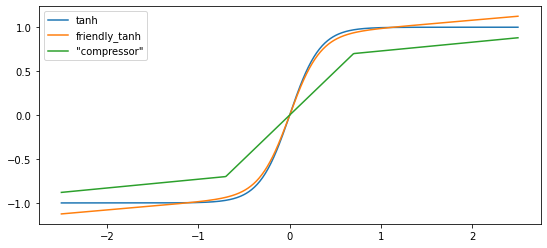

In [13]:
x = torch.linspace(-2.5,2.5,500)
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(x.cpu().numpy(), torch.tanh(3*x).cpu().numpy(), label='tanh')
ax.plot(x.cpu().numpy(), friendly_tanh(x,a=3).cpu().numpy(), label='friendly_tanh')
ax.plot(x.cpu().numpy(), compressor(x).cpu().numpy(), label='"compressor"')
ax.legend()

In [14]:
#| export    
class TwistAndScrunch(nn.Module):
    """for now just something random with a bit of nonlinearity
    """
    def __init__(self, 
        scrunch_fac=1.7, twist_fac=0.2, debug=False, act=nn.GELU(),
        in_dims=2,        # number of input dimensions to use
        hidden_dims=32,   # number of hidden dimensions
        emb_dims=2,       # number of output dimensions to use
        trans='trans2'  # choice of (invertible) nonlinear transformation functions
        ): 
        super().__init__()
        self.sf, self.tf, self.debug, self.trans = scrunch_fac, twist_fac, debug, trans

        self.pi = torch.acos(torch.zeros(1)).item() * 2

        self.encoder = nn.Sequential(   # note that this is not going to be used.
            #EmbedBlock(emb_dims, in_dims),
            EmbedBlock(emb_dims, hidden_dims, act=act),
            EmbedBlock(hidden_dims, hidden_dims, act=act),            
            nn.Linear(hidden_dims, in_dims)
        )
        self.decoder = nn.Sequential(  
            #EmbedBlock(emb_dims, in_dims),
            EmbedBlock(emb_dims, hidden_dims, act=act),
            EmbedBlock(hidden_dims, hidden_dims, act=act),            
            nn.Linear(hidden_dims, in_dims)
        )      
    
    def encode(self, v):
        vp = v.clone()    # v prime.  new point.
        if self.trans=='trans2':  # little simpler, still works.
            vp[:,0], vp[:,1] = vp[:,0] - 0.5*friendly_tanh(v[:,1],a=3), vp[:,1] + 0.7*friendly_tanh(v[:,0],a=1.2)
        else:  # 'classic twist'
            r = torch.norm(v, dim=1).unsqueeze(0)
            new_r = torch.tanh(r) #torch.tanh(r * self.sf)
            rfac = torch.exp(r/new_r)
            vp[:,0], vp[:,1] = v[:,0]*new_r/r - self.tf*(v[:,1]*rfac - v[:,0]), v[:,1]*new_r/r + self.tf*(v[:,0]*rfac - v[:,1])

        emb = friendly_tanh(self.sf*vp,a=2,b=0.1)
        return emb
    
    def decode(self, emb, exact=False):
        if exact and self.trans=='classic twist':
            vp = emb*2 
            v[:,0], v[:,1] = vp[:,0]/new_r*r - self.tf*v[:,1]*rfac, v[:,1]*new_r/r + self.tf*v[:,0]*rfac
        else:
            recon = self.decoder(emb)
        return recon
        
    def forward(self, x, debug=False, exact=False):
        debug_save, self.debug = self.debug, debug  # only turn on debug for this one call
        emb = self.encode(x)
        outs =  self.decode(emb, exact=exact), emb
        self.debug = debug_save
        return outs

## Visualize Effects of (Uninitialized) Given Model on Data

In [15]:
torch.manual_seed(seed)
#given_model = SimpleAutoEncoder(in_dims=in_dims, emb_dims=emb_dims).to(device)
given_model = TwistAndScrunch()

In [16]:
given_model = given_model.to(device)

for single stem:
absmax of val_batch =  0.9996815919876099
absmax of emb_batch =  1.141883134841919


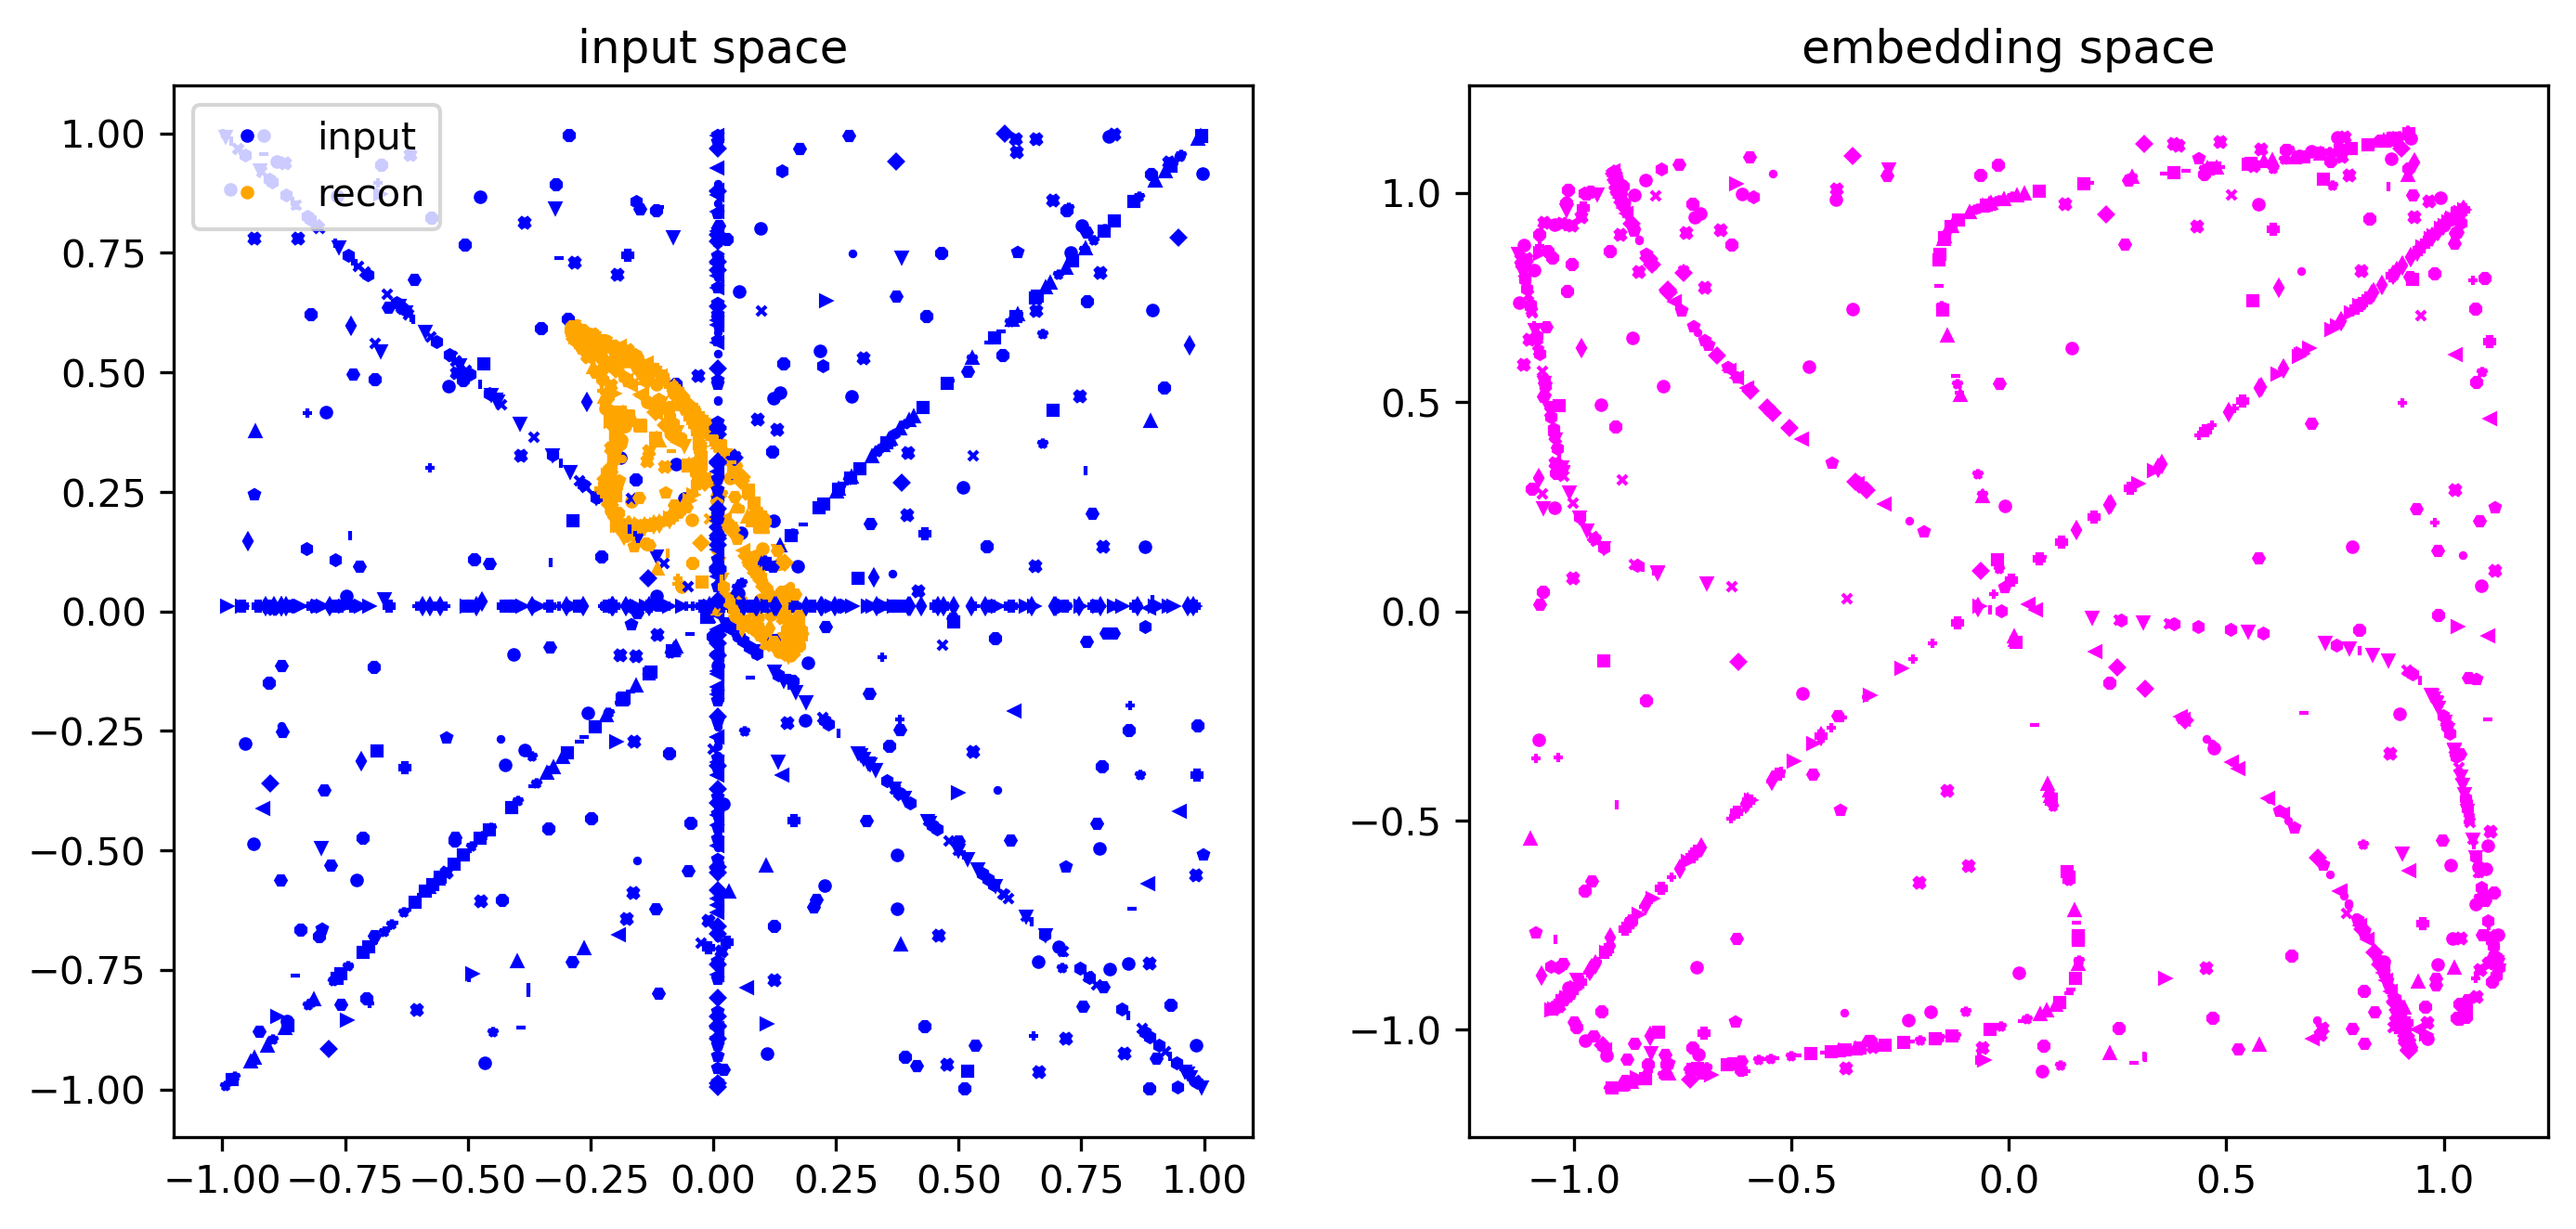

In [17]:
#|export
def viz_given_batch(
    val_batch,            # should be from val_batch
    given_model,         # the main autoencoder model we are splicing into
    aa_model=None,       # our audio algebra model
    debug=False, 
    device=get_device(),
    return_img = True,
    show_recon=True,
    ):
    markers=['o', '+', 'x', '*', '.', 'X', "v", "^", "<", ">", "8", "s", "p", "P", "h", "H", "D", "d","|","_"]
    colors=['blue', 'magenta','orange', 'green', 'red', 'cyan', 'black']
    markersize=2.5
    
    val_batch = val_batch.to(device)
    
    with torch.no_grad():
        emb_batch = given_model.encode(val_batch)
        recon_batch = given_model.decode(emb_batch)
        
    fig, ax = plt.subplots(1,2, figsize=(11,5))
    ax[0].set_title(f"input space")
    ax[1].set_title(f"embedding space")
    
    if debug: 
        print("absmax of val_batch = ",torch.abs(val_batch).max().item())
        print("absmax of emb_batch = ",torch.abs(emb_batch).max().item())
    
    nm = len(markers)
    for mi in range(nm):
    #for i in range(val_batch.shape[0]):  # TODO: looping over every points is very slow, but apparently needed for arrows
        for bi,b in enumerate([val_batch, emb_batch, recon_batch]):
            x, y = b[mi::nm,0].cpu().numpy(), b[mi::nm,1].cpu().numpy()
            if (bi<2) or show_recon: ax[bi%2].plot(x, y, marker=markers[mi], markersize=markersize, color=colors[bi], linestyle='None', label='' if mi > 0 else ['input', 'embedding', 'recon'][bi])
    ax[0].legend(loc='upper left')
    val_plot_fname = f'{SCRATCH_DIR}/val_plot{RUN_SUFFIX}{random.randint(1,5)}.png'
    plt.savefig(val_plot_fname, bbox_inches='tight', dpi=300)
    plt.close()
    im = Image.open(val_plot_fname)
    return im

print("for single stem:")
viz_given_batch(demo_batch, given_model, debug=True)

demo mix:
absmax of val_batch =  1.9301079511642456
absmax of emb_batch =  1.2925496101379395


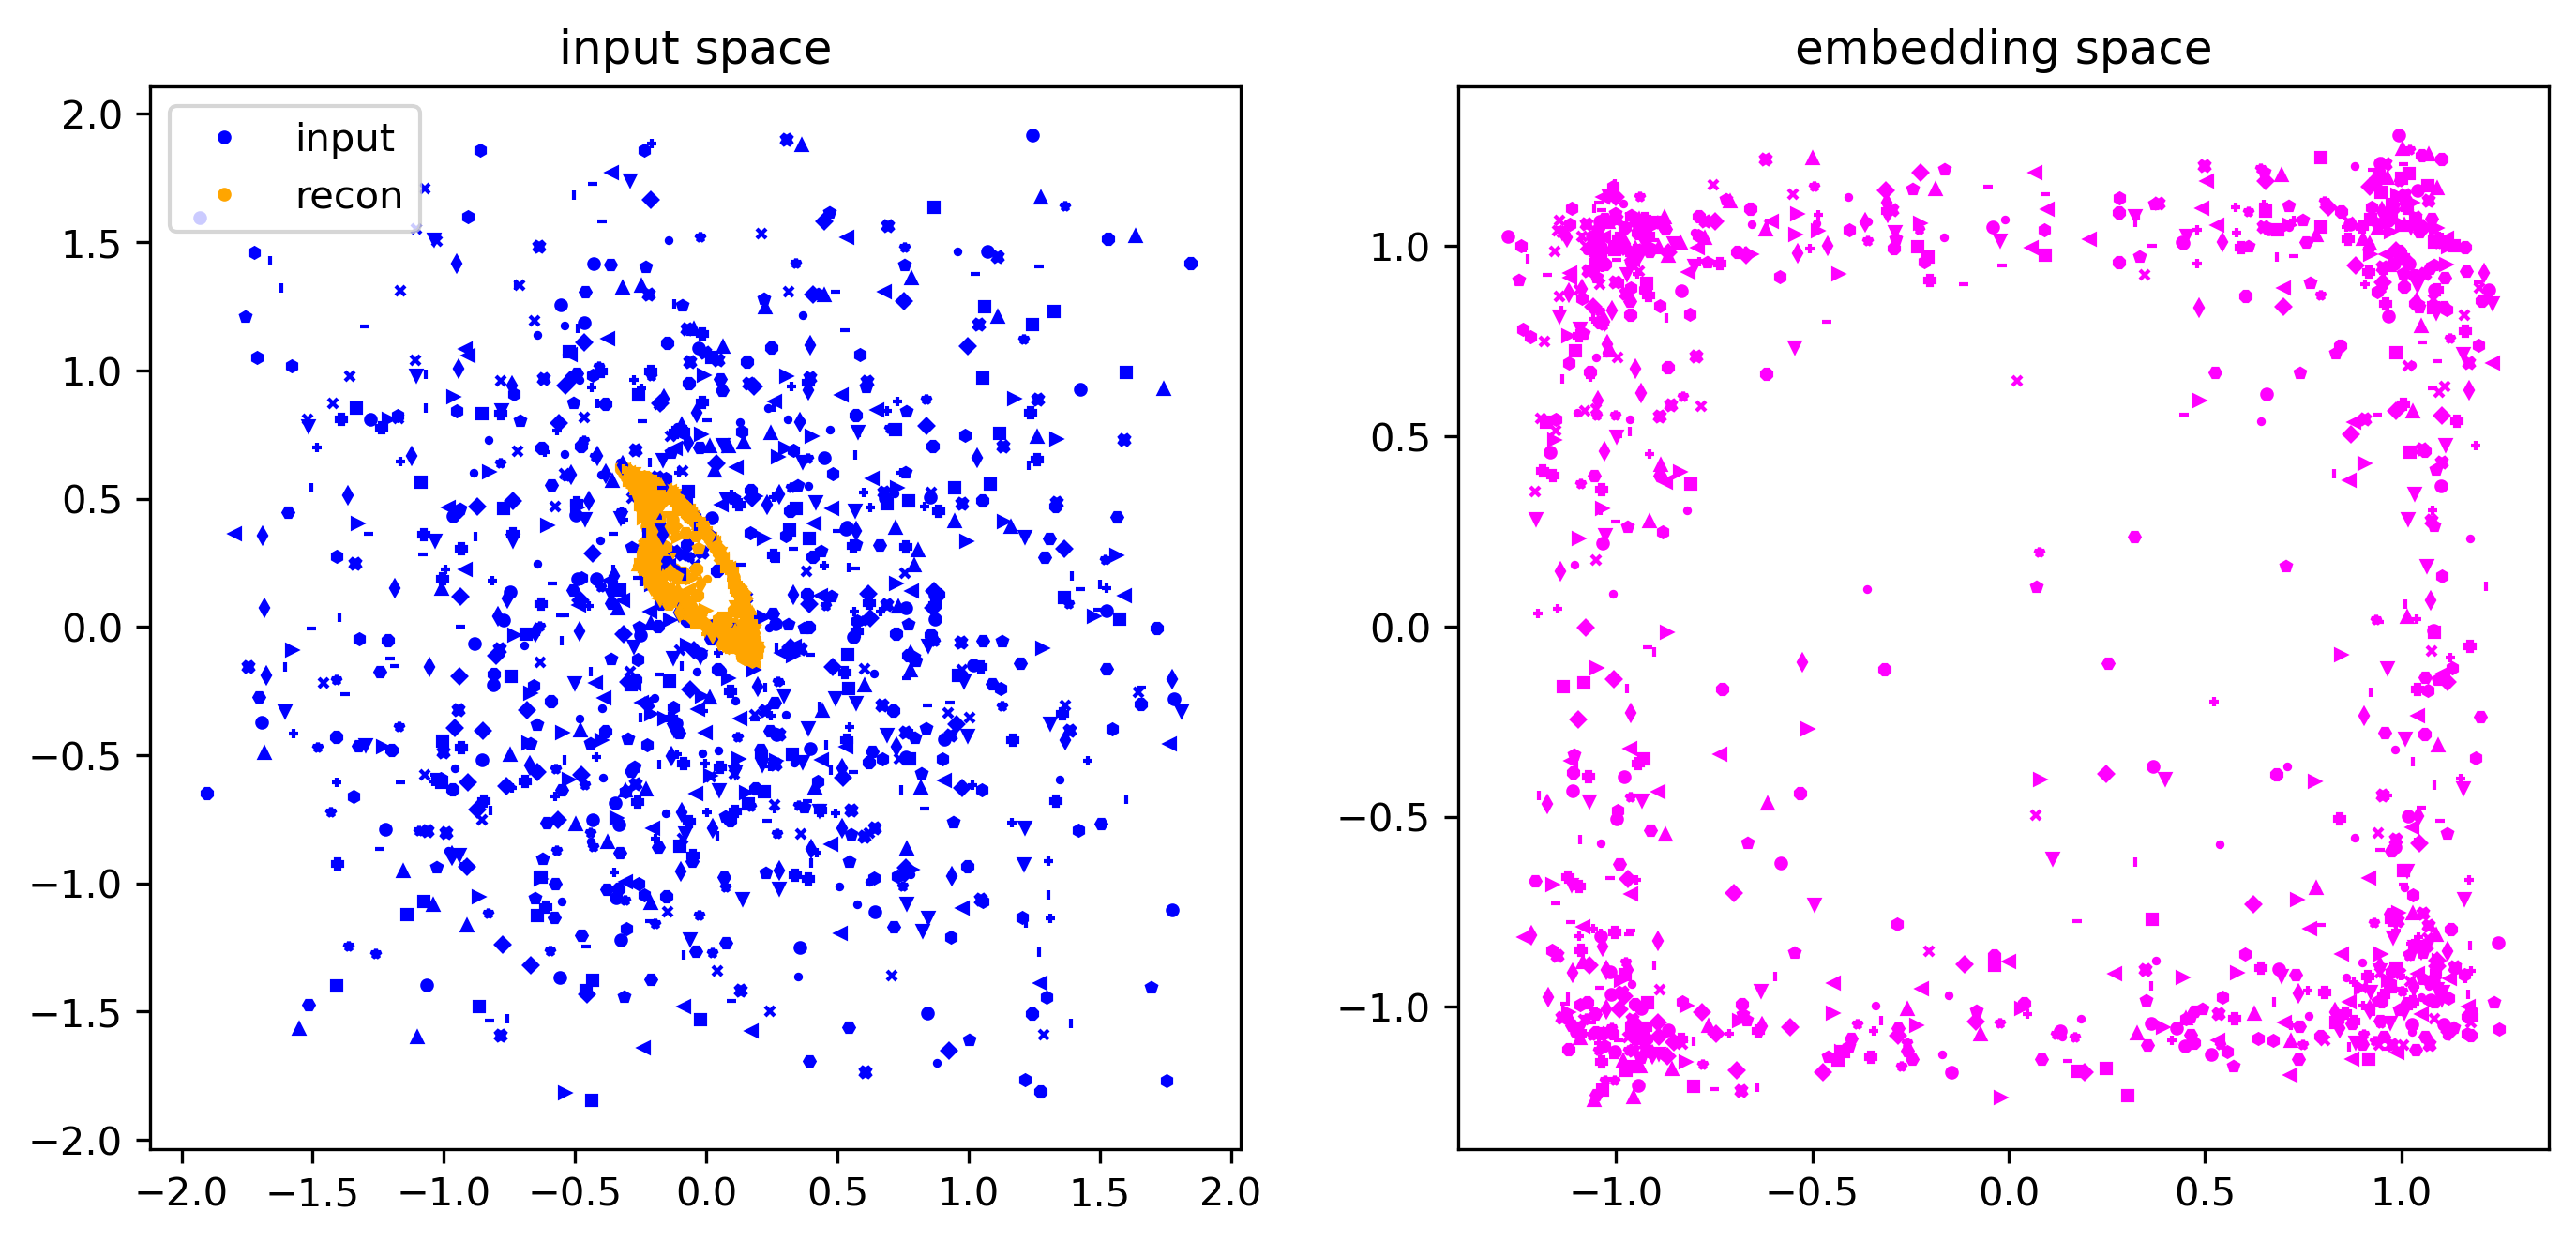

In [18]:
print("demo mix:")
viz_given_batch(demo_mix, given_model, debug=True)

In [19]:
# this cell deliberately left blank to make viewing above plot easier

# (Optional) Train the [Decoder of the] Given AutoEncoder

In the real case we can skip this, but for the toy model we should make sure the given model is a real autoencoder

In [20]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: drscotthawley. Use `wandb login --relogin` to force relogin


True

In [21]:
retrain_given_model = True

if retrain_given_model: 
    opt_given = optim.Adam(given_model.parameters(), lr=5e-4)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_given, 'min', factor=0.3, verbose=True)
    mseloss = nn.MSELoss()

    wandb.finish()
    wandb.init(project='aa-toy-given')
    epoch, step, max_epochs = 0, 0, 20
    lossinfo_every, demo_every =   20, 1000   # in unites of steps
    freeze_enc_at = 65  # if we don't freeze the encoder early on, then it linearizes everything, making the challenge for aa too easy.  
    debug = False

    total_steps = len(train_dataset)//batch_size * max_epochs
    print("total_steps = ",total_steps)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(opt_given, max_lr=0.025, total_steps=total_steps)

    while epoch < max_epochs:  # training loop
        with tqdm(train_dl, unit="batch") as tepoch:
            for batch in tepoch:   # training
                opt_given.zero_grad()

                batch = (2*torch.rand(batch.shape)-1).to(device)                 
                batch_out, emb = given_model(batch)
                batch_loss = mseloss(batch_out, batch)
                
                mix = batch + (2*torch.rand(batch.shape)-1).to(device) #  "the mix"
                mix_out, emb2 = given_model(mix)
                mix_loss = mseloss(mix_out, mix)
                
                loss = batch_loss + mix_loss 
                
                #if step <= freeze_enc_at:
                #    loss += 0.001*mseloss(emb, 0*emb)  # wee bit of L2 decay on given embeddings
                log_dict = {}
                log_dict['train_loss'] = loss.detach()
                log_dict['learning_rate'] = opt_given.param_groups[0]['lr']
                
                if step % lossinfo_every == 0: 
                    tepoch.set_description(f"Epoch {epoch+1}/{max_epochs}")
                    tepoch.set_postfix(loss=loss.item())

                if step == freeze_enc_at:  # freeze encoder after this many steps
                    print(f"Step = {step}: Freezing encoder.")
                    for param in given_model.encoder.parameters():
                        param.requires_grad = False
                    given_model.encoder.train(False)
                    given_model.encoder.eval()

                loss.backward()
                opt_given.step() 

                # run on validation set
                with torch.no_grad():
                    val_batch = next(iter(val_dl)).to(device)
                    val_mix = val_batch + next(iter(val_dl)).to(device)

                    val_batch_out, emb = given_model(val_batch)
                    val_batch_loss = mseloss(val_batch_out, val_batch)
                    
                    val_mix_out, emb2 = given_model(val_mix)
                    val_mix_loss =  mseloss(val_mix_out, val_mix)
                    
                    val_loss = val_batch_loss + val_mix_loss
                    log_dict['val_batch_loss'] = val_batch_loss.detach()
                    log_dict['val_mix_loss'] = val_mix_loss.detach()
                    log_dict['val_loss'] = val_loss.detach()

                    if step % demo_every == 0:
                        log_dict["given_map_demo_batch"] = wandb.Image(viz_given_batch(demo_batch, given_model))
                        log_dict["given_map_demo_mix"] = wandb.Image(viz_given_batch(demo_mix, given_model))
                        log_dict["outs_hist"] = wandb.Histogram(batch_out.cpu().detach().numpy())
                        log_dict["emb_hist"] = wandb.Histogram(emb.cpu().detach().numpy())

                wandb.log(log_dict)
                step += 1
                
                scheduler.step()# val_loss)    

        epoch += 1
        #print("")
        
    wandb.finish()


total_steps =  40000


  0%|          | 0/2000 [00:00<?, ?batch/s]

Step = 65: Freezing encoder.


  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

learning_rate,▁▁▂▂▃▄▅▆▆▇███████▇▇▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_batch_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mix_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,0.0
train_loss,1e-05
val_batch_loss,0.0
val_loss,2e-05
val_mix_loss,1e-05


for single stem:


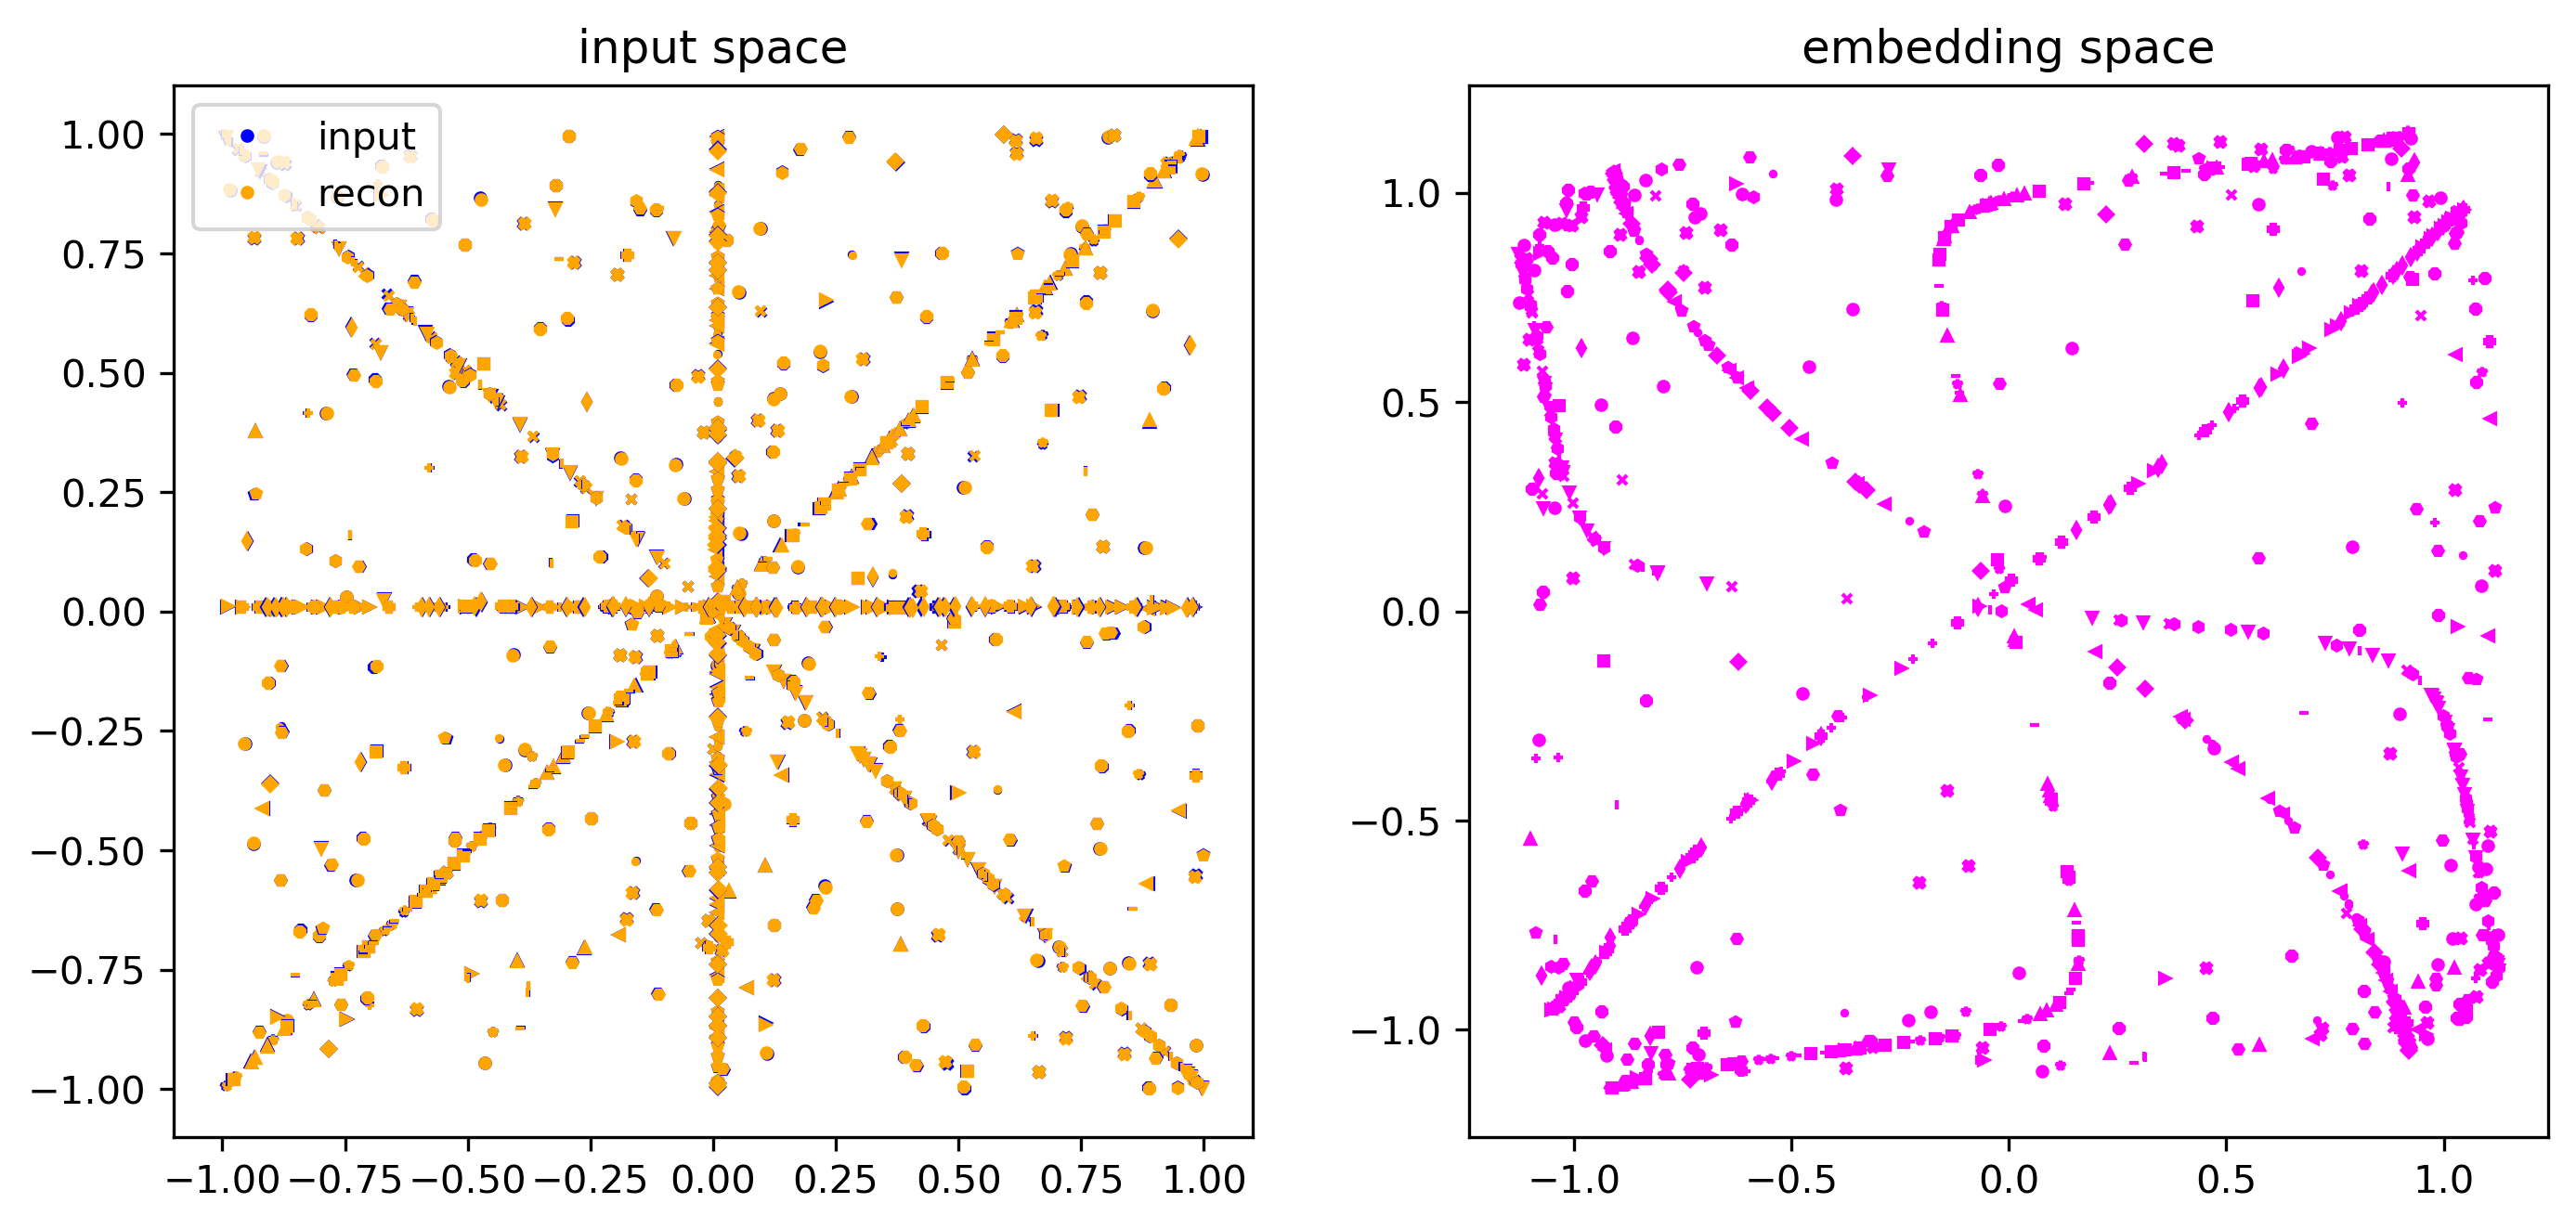

In [22]:
print("for single stem:")
viz_given_batch(demo_batch, given_model)

demo mix


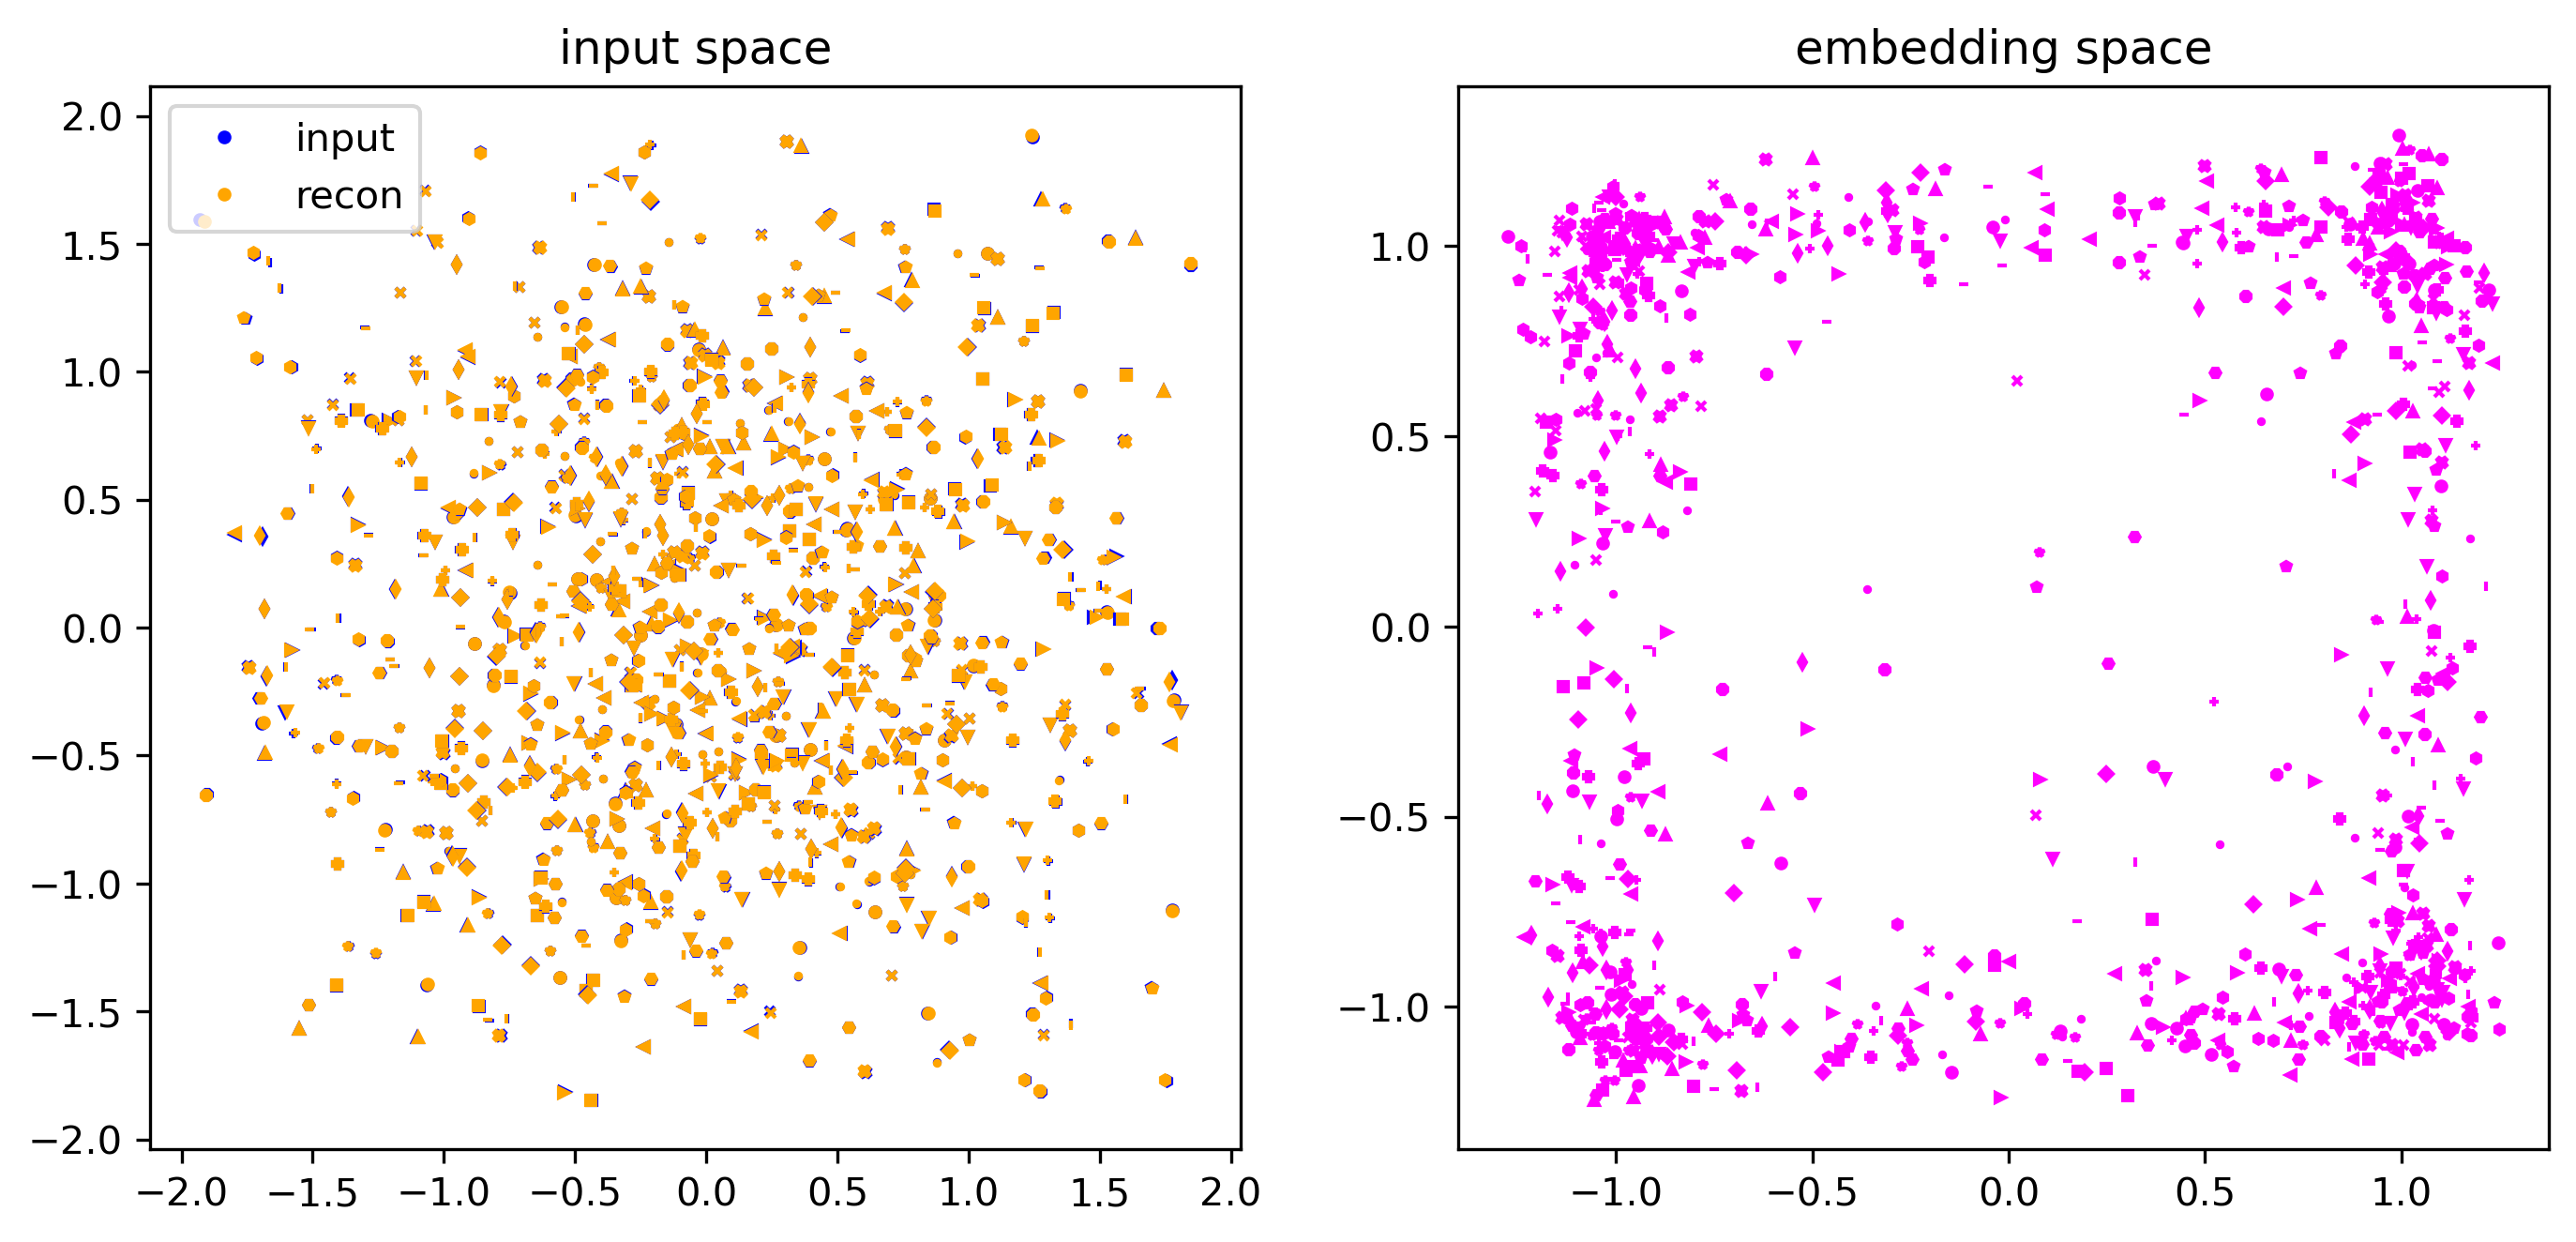

In [23]:
print("demo mix")
viz_given_batch(demo_mix, given_model)

### Save the model

In [24]:
if retrain_given_model:
    given_path = 'given_model.pth'
    torch.save(given_model.state_dict(), given_path)

### Load the given model 

In [25]:
given_path = 'given_model.pth'
given_model = TwistAndScrunch() # GivenAutoEncoder(in_dims=in_dims, act=act, emb_dims=emb_dims)
given_model.load_state_dict(torch.load(given_path))
given_model.to(device)
given_model.eval()

TwistAndScrunch(
  (encoder): Sequential(
    (0): EmbedBlock(
      (act): GELU()
      (lin): Linear(in_features=2, out_features=32, bias=True)
    )
    (1): EmbedBlock(
      (act): GELU()
      (lin): Linear(in_features=32, out_features=32, bias=True)
    )
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): EmbedBlock(
      (act): GELU()
      (lin): Linear(in_features=2, out_features=32, bias=True)
    )
    (1): EmbedBlock(
      (act): GELU()
      (lin): Linear(in_features=32, out_features=32, bias=True)
    )
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)

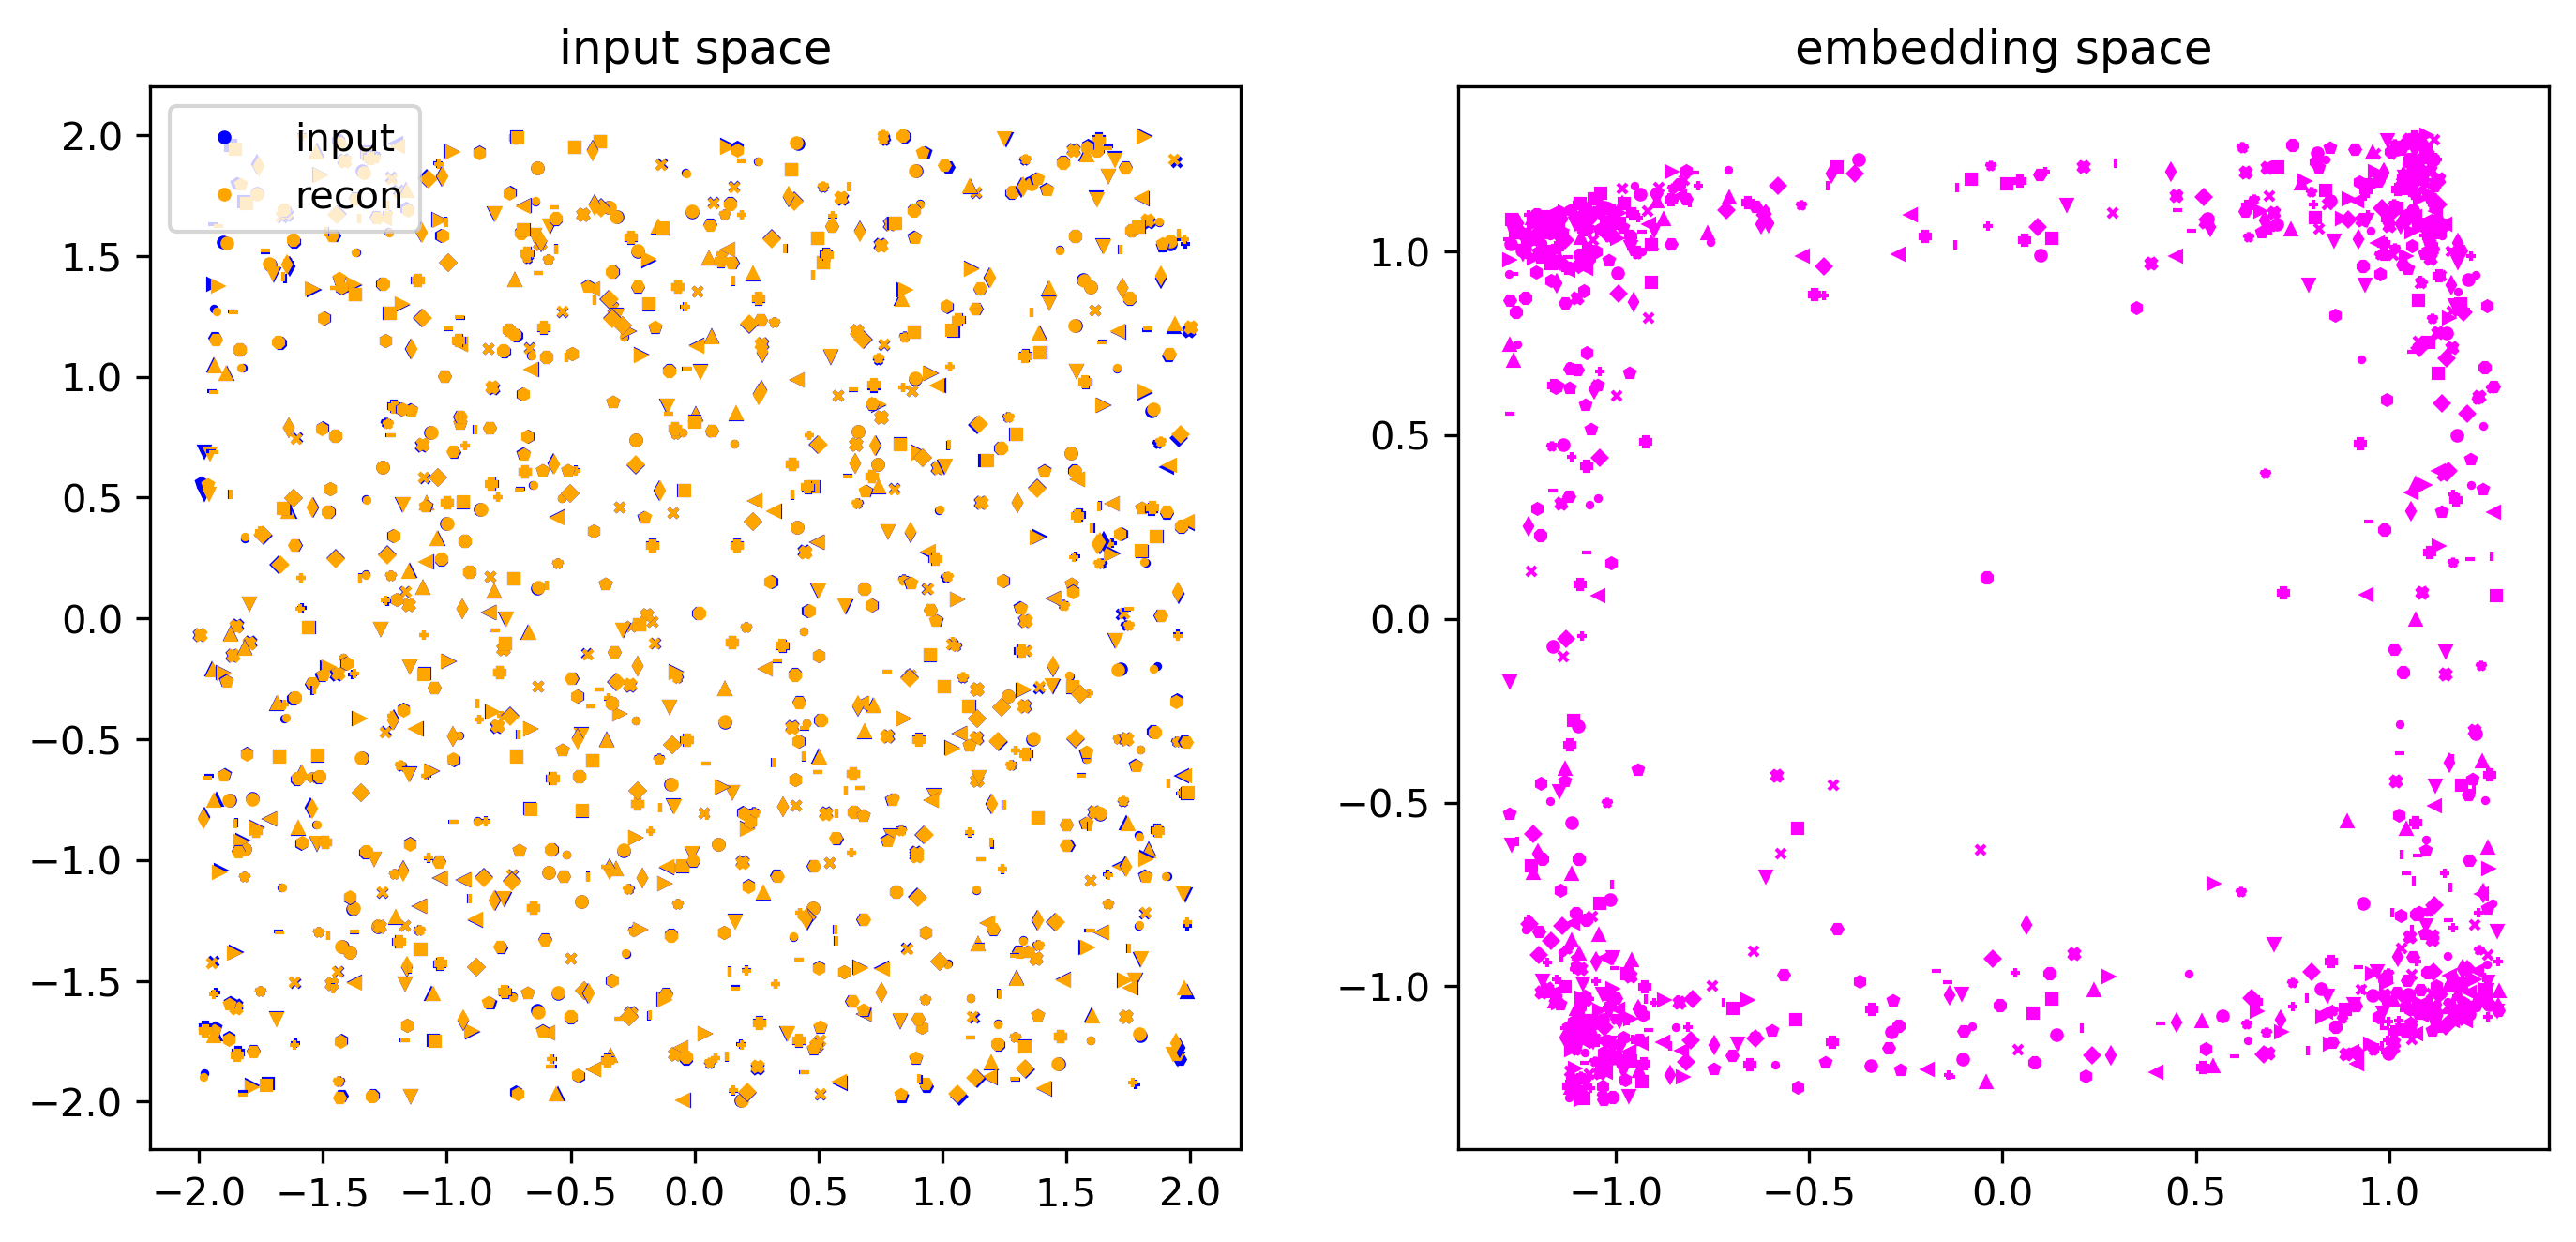

In [26]:
viz_given_batch(2*(2*torch.rand(demo_batch.shape)-1), given_model, show_emb_rec_arrows=False)

# The AA-mixer model: now our 'Inserted AutoEncoder'
this is the model that we will train

In [27]:
#| export
class AudioAlgebra(nn.Module):
    """
    Main AudioAlgebra model. Contrast to aa-mixer code, keep this one simple & move mixing stuff outside
    """
    def __init__(self, dims=2, hidden_dims=64, act=nn.GELU(), use_bn=False, resid=True, block=EmbedBlock):
        super().__init__()
        self.encoder = nn.Sequential(  
            block( dims,        hidden_dims, act=act,  use_bn=use_bn, resid=resid),
            block( hidden_dims, hidden_dims, act=act,  use_bn=use_bn, resid=resid),
            block( hidden_dims, hidden_dims, act=act,  use_bn=use_bn, resid=resid),
            block( hidden_dims, dims,        act=None, use_bn=use_bn, resid=resid),
        )
        self.decoder = nn.Sequential(  # same as encoder, in fact. 
            block( dims,        hidden_dims, act=act,  use_bn=use_bn, resid=resid),
            block( hidden_dims, hidden_dims, act=act,  use_bn=use_bn, resid=resid),
            block( hidden_dims, hidden_dims, act=act,  use_bn=use_bn, resid=resid),   
            block( hidden_dims, dims,        act=None, use_bn=use_bn, resid=resid),
        )
            
    def encode(self,x):
        return x + self.encoder(x) 

    def decode(self,x):
        return x + self.decoder(x)

    def forward(self, 
        x   # the enbedding vector from the given encoder
        ):
        xprime = self.encode(x)
        xprimeprime = self.decode(xprime)  # train system to invert itself (and hope it doesn't all collapse to nothing!)
        return xprime, xprimeprime  # encoder output,  decoder output

### get_stems_faders:
really this is more of a `dataloader` utility but for now its being called from the main loop because it involves less change to the dataloader. ;-) 

In [28]:
#| export 
def get_stems_faders(batch, #  "1 stem" (or batch thereof) already drawn fron the dataloader (val or train)
                     dl_iter,  # pre-made the iterator for the/a dataloader
                     dl,       # the dataloader itself, for restarting
                     maxstems=2,  # how many total stems will be used, i.e. draw maxstems-1 new stems from dl_iter
                     unity_gain=False,  # this will force all faders to be +/-1 instead of random numers
                     debug=False):
    "grab some more inputs and multiplies and some gain values to go with them"
    nstems = random.randint(2, maxstems)
    if debug: print("maxstems, nstems =",maxstems, nstems)
    device=batch.device
    faders = torch.sgn(2*torch.rand(nstems)-1)  # random +/- 1's
    if not unity_gain:
        faders += 0.5*torch.tanh(2*(2*torch.rand(nstems)-1))  # gain is now between 0.5 and 1.5
    stems = [batch]                  # note that stems is a list
    for i in range(nstems-1):        # in addtion to the batch of stem passed in, grab some more
        try: 
            next_stem = next(dl_iter).to(device)    # this is just another batch of input data
        except StopIteration:
            dl_iter = iter(dl)       # time to restart. hoping this propagates out as a pointer
            next_stem = next(dl_iter).to(device)
        if debug: print("  next_stem.shape = ",next_stem.shape)
        stems.append(next_stem)
    return stems, faders.to(device), dl_iter  # also return the iterator

Code to to do the encoding of stems and faders into zmix and zsum

* zmix = embedding of the mix (mix = sum of inputs in input space)
* zsum = mix of the embeddings (in embedding space

In [29]:
def do_mixing(stems, faders, given_model, aa_model, device, debug=False, **kwargs):
    """
    here we actually encode inputs.
    0's denote values in the given model space, non-0's denode those in our aa_model
    e.g., "z0" denotes an embedding from the frozen encoder, "z" denotes re-mapped embeddings

    """
    zs, z0s, zsum, z0sum, z0recon_sum, fadedstems = [], [], None, None, None, []
    mix = torch.zeros_like(stems[0]).to(device)
    #if debug: print("do_mixing: stems, faders =",stems, faders)
    for s, f in zip(stems, faders):   # iterate through list of stems, encode a bunch of stems at different fader settings
        fadedstem = (s * f).to(device)                 # audio stem adjusted by gain fader f
        with torch.no_grad():
            z0 = given_model.encode(fadedstem)  # encode the stem
        z, z0_recon = aa_model(z0)             # <-- this is the main work of the model
        zsum = z if zsum is None else zsum + z # <---- compute the sum of all the z's so far. we'll end up using this in our (metric) loss as "pred"

        mix += fadedstem                 # make full mix in input space
        with torch.no_grad():
            z0mix = given_model.encode(mix)  # encode the mix in the given model
        zmix, z0mix_recon = aa_model(z0mix)   #  <----- map that according to our learned re-embedding. this will be the "target" in the metric loss

        # for diagnostics:
        z0sum = z0 if z0sum is None else z0sum + z0   # = sum of embeddings in original model space; we don't really care about z0sum except for diagnostics
        z0recon_sum = z0_recon if z0recon_sum is None else z0recon_sum + z0_recon   # = sum of embeddings in original model space; we don't really care about z0sum except for diagnostics

        zs.append(z)              # save a list of individual z's
        z0s.append(z0)            # save a list of individual z0's
        fadedstems.append(fadedstem) # safe a list of each thing that went into the mix
        
    archive = {'zs':zs, 'mix':mix, 'znegsum':None, 'z0s': z0s, 'z0sum':z0sum, 'z0mix':z0mix, 'z0mix_recon':z0mix_recon, 'z0recon_sum':z0recon_sum, 'fadedstems':fadedstems} # more info for diagnostics

    return zsum, zmix, archive  # we will try to get these two to be close to each other via loss. archive is for diagnostics

### Instantiate the model

In [30]:
aa_use_bn = False  # batch norm? 
aa_use_resid = True # use residual connections? (doesn't make much difference tbh)
hidden_dims = 64   # number of hidden dimensions in aa model. usually was 64

torch.manual_seed(seed) # chose this value because it shows of nice nonlinearity
aa_model = AudioAlgebra(dims=emb_dims, hidden_dims=hidden_dims, use_bn=aa_use_bn, resid=aa_use_resid).to(device) 

...and visualize its effects

In [35]:
#|export
def multimarkerplot(ax, data, color='blue', markersize=2.7, label=''):
    "little thingy for using lots of symbols for a plot"
    markers = ['o', '+', 'x', '*', '.', 'X', "v", "^", "<", ">", "8", "s", "p", "P", "h", "H", "D", "d","|","_"]
    nm = len(markers)
    for mi in range(nm):
        ax.plot(data[mi::nm,0], data[mi::nm,1], marker=markers[mi], markersize=markersize, color=color, linestyle='None', label=label if mi==0 else '') 

    
def viz_aa_demo(
    zsum, zmix,
    archive,
    aa_model=None,
    projector=None,
    debug=False,
    ):
    "for visualizing what aa model is doing"
    colors=['blue', 'red', 'green', 'magenta', 'orange', 'cyan', 'black',]
    
    
    col_labels = ["inputs", "given embs", "aa embs"]
    nrows, ncols = 2, len(col_labels)
    if projector: ncols += 1  # put projector on extra last column if wanted
    figsize = (4*ncols, 4*nrows)
    fig, ax = plt.subplots(nrows,ncols, figsize=figsize)
    
    # top row: stems*faders,  z0s,  zs:  each of these is a list
    keys = ['fadedstems', 'z0s', 'zs']    
    for coli, key in enumerate(keys):
        ax[0,coli].set_title(f"{col_labels[coli]}: {key}")
        datalist = [x.detach().cpu().numpy() for x in archive[key]]
        for i, data in enumerate(datalist):
            multimarkerplot( ax[0,coli], data, color=colors[i] )

    # bottom row: mix
    archive["zmix"] = zmix  # lil prep
    keys = ['mix', 'z0mix', 'zmix']
    for coli, key in enumerate(keys):
        ax[1,coli].set_title(f"{col_labels[coli]}")
        data = archive[key].detach().cpu().numpy()
        multimarkerplot( ax[1,coli], data, label=key, color=colors[2])
        if key=='z0mix':
            #multimarkerplot( ax[1,coli], archive["z0sum"].detach().cpu().numpy(), label='z0sum', color=colors[3])
            multimarkerplot( ax[1,coli], archive["z0mix_recon"].detach().cpu().numpy(), label='z0mix_recon', color=colors[4])
            #multimarkerplot( ax[1,coli], archive["z0recon_sum"].detach().cpu().numpy(), label='z0recon_sum', color=colors[5])
        elif key=='zmix': 
            multimarkerplot( ax[1,coli], zsum.detach().cpu().numpy(), label='zsum', color=colors[3])
        ax[1,coli].legend(fancybox=True, framealpha=0.6, loc='upper left', prop={'size': 8})
        
    if debug: print("saving to file")
    filename = f'{SCRATCH_DIR}/aa_val_plot{RUN_SUFFIX}.png'
    plt.savefig(filename, bbox_inches='tight', dpi=225)
    plt.close()
    if debug: print("loading file")
    im = Image.open(filename)
    return im

maxstems, nstems = 2 2
  next_stem.shape =  torch.Size([1024, 2])
demo_faders =  tensor([-0.7648, -0.5232])
calling do_mixing...
calling viz_aa_batch...


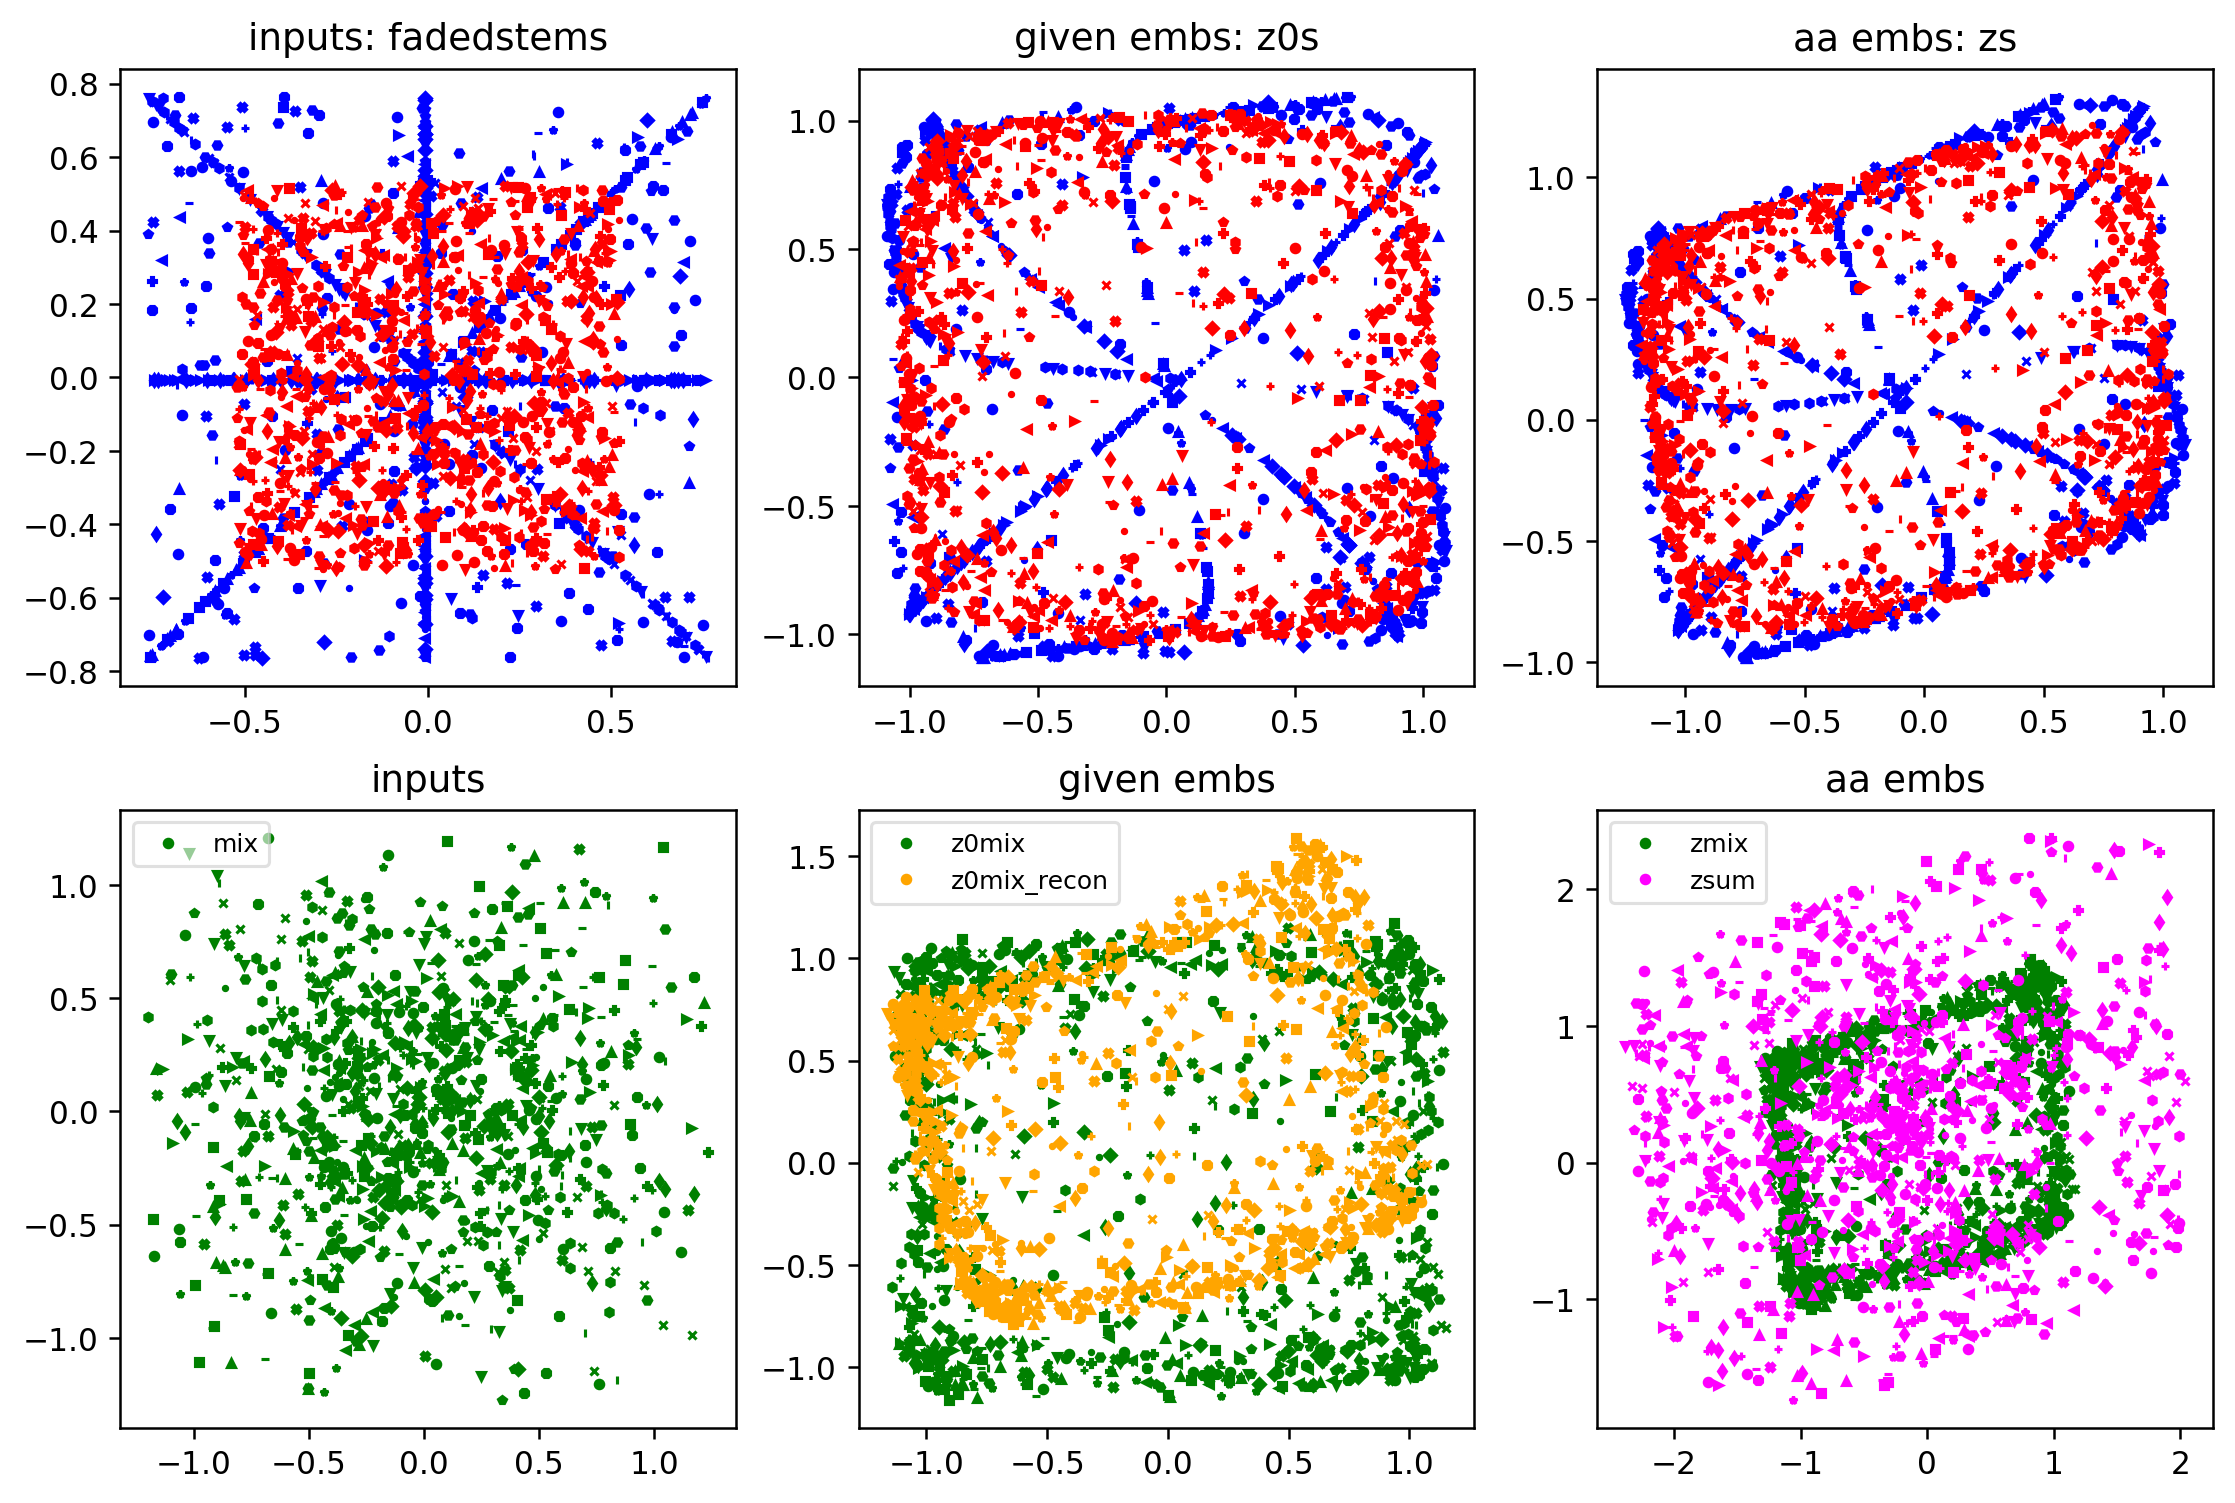

In [36]:
# test the viz
demo_stems, demo_faders, val_iter = get_stems_faders(demo_batch, val_iter, val_dataset, debug=True, unity_gain=False, maxstems=2)
print("demo_faders = ",demo_faders)
print("calling do_mixing...")
demo_zsum, demo_zmix, demo_archive = do_mixing(demo_stems, demo_faders, given_model, aa_model, device, debug=True)

print("calling viz_aa_batch...")
im = viz_aa_demo(demo_zsum, demo_zmix, demo_archive, aa_model=aa_model, debug=False)
im

The fact that zsum and zmix (top right) are not the same is the problem that our aa-mixer model will try to put right. 

In [37]:
# left blank to facilitate viewing graph above

Define some losses

In [38]:
mseloss = nn.MSELoss()
def rel_loss(y_pred: torch.Tensor, y: torch.Tensor, eps=1e-3) -> float:
    "relative error loss"
    e = torch.abs(y.view_as(y_pred) - y_pred) / ( torch.abs(y.view_as(y_pred)) + eps ) 
    return torch.median(e)

We could try to train the model now, but the representations would collapse, either toward the origin or toward a line. 

# Avoiding Collapse: VICReg
This sort of this has been some of the primary outputs of the Meta AI (Yann LeCun et al)'s work on Self-Supervised Learning (SSL) of representations.  Mostly they're interested in classification of images, but we will try to adapt this to our purposes.  A few notable papers, in chronological and topical order:

* BYOL (Grill et al, 2020). I wrote about this in [my blog](https://drscotthawley.github.io/blog_quarto/posts/2022-11-17-byol.html). BYOL is fine but typically regarded as being more geared toward classification rather than regression. 
* VICReg (Bardes et al, 2022) [PDF](https://arxiv.org/pdf/2105.04906.pdf) introduces "variance-invariance-covariance regularization. This is what we'll follow here.  
* VCReg (Mialon et al, 2022) [PDF](https://arxiv.org/pdf/2209.14905.pdf) is about gaining an understanding of why the "projector"(/"expander") network is useful (rather than the mere observation that is *is*. 

The VICReg paper's architecture diagram and figure caption is as follows: 
![vicreg_diagram](https://github.com/facebookresearch/vicreg/raw/main/.github/vicreg_archi_full.jpg)
> "Figure 1: **VICReg: joint embedding architecture with variance, invariance and covariance
regularization.** Given a batch of images I, two batches of different views X and X0 are produced
and are then encoded into representations Y and Y0. The representations are fed to an expander
producing the embeddings Z and Z0. The distance between two embeddings from the same image is
minimized, the variance of each embedding variable over a batch is maintained above a threshold, and
the covariance between pairs of embedding variables over a batch are attracted to zero, decorrelating
the variables from each other. Although the two branches do not require identical architectures nor
share weights, in most of our experiments, they are Siamese with shared weights: the encoders are
ResNet-50 backbones with output dimension 2048. The expanders have 3 fully-connected layers of
size 8192." -- Bardes et al

As explained in the "VICReg: Intuition" section of the paper: 

> "The basic idea is to use a loss function with three terms:
> * **Invariance**: the mean square distance between the embedding vectors.
> * **Variance**: a hinge loss to maintain the standard deviation (over a batch) of each variable of
the embedding above a given threshold. This term forces the embedding vectors of samples
within a batch to be different.
> * **Covariance**: a term that attracts the covariances (over a batch) between every pair of
(centered) embedding variables towards zero. This term decorrelates the variables of each
embedding and prevents an informational collapse in which the variables would vary
together or be highly correlated."

### Invariance 
The **invariance** part is easy.  But that's what leads to collapse. 

### Variance 
The **variance** part is about using a hinge loss on some scale $\gamma$ ("fixed to $1$ in our experiments") minus the standard deviation $S$ across each dimension $j$ (for $d$ dimensions) within the batch $Z$: 

$$    v(Z) = \frac{1}{d} \sum_{j=1}^{d} \max(0, \gamma - S(z^{j}, \epsilon))   $$ 
where $z^j$ denotes "the vector composed of each value at dimension $j$ in
all vectors in $Z$," and $\epsilon$ is some small constant to prevent numerical instability, i.e.:

$$     S(x, \epsilon) = \sqrt{\mathrm{Var}(x) + \epsilon} $$

In other words, they're trying to make sure the variance doesn't get any smaller than $\gamma$ (but larger than $\gamma$ is fine). 

> Note:  I tried *something like that* in my earlier training code, and it didn't help.
Specifically, what I'd had was something whereby the (2 x 2) covariance matrix doesn't really change over time: 

```python
    # (co)variance loss - try to stabilize variance to prevent collapse
    if step==0: # save variance of a batch of input data
        z0s_tensor = rearrange(torch.stack(archive['z0s']), 'a b c -> (a b) c') # z0s list into long tensor
        var_z0s = torch.cov( z0s_tensor.T )      # without the .T we get (bs,bs) instead of (2,2)

    zs_tensor = rearrange( torch.stack(archive['zs']), 'a b c -> (a b) c') 
    var_zs = torch.cov( zs_tensor.T )
    var_loss = mseloss( var_z0s, var_zs )
```
> ...but the model didn't know how to train with that. 

Anyway, let's adapt the code from the [VICReg repo](https://github.com/facebookresearch/vicreg/blob/4e12602fd495af83efd1631fbe82523e6db092e0/main_vicreg.py#LL205-L207C89):

In [39]:
#| export
def vicreg_var_loss(z, gamma=1, eps=1e-4):
    std_z = torch.sqrt(z.var(dim=0) + eps)
    return torch.mean(F.relu(gamma - std_z))   # the relu gets us the max(0, ...)

Note: The authors say, "Using the standard deviation and not directly the variance is crucial."

### Covariance
What about the **covariance** term?  This is another way to prevent collapse.  While the invariance can prevent collapse toward zero, the covariance can prevent collapse to a constant vector.  This part I did not have! Or at least didn't have it right. For the covariance, we need a notion of "what should be different" -- easy! We'll just use other elements within the same batch! 

Let's adapt the [VICReg code](https://github.com/facebookresearch/vicreg/blob/4e12602fd495af83efd1631fbe82523e6db092e0/main_vicreg.py#LL209-L213C69):

In [40]:
#| export
def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

def vicreg_cov_loss(z):
    "the regularization term that is the sum of the off-diagaonal terms of the covariance matrix"
    # zn = z - z.mean(dim=0)
    # cov_z = ((zn.T @ zn) / (z.shape[0] - 1)
    cov_z = torch.cov(z.T) #   
    return off_diagonal(cov_z).pow_(2).sum().div(z.shape[1])

### Projector aka Expander $h_\phi$
The VICReg method includes an additional projector model.  

Our AA model actually functions like a projector, so in my experiments I didn't notice any advantage to having one. 

I'm going to define the projector but leave it turned off by default

In [41]:
#| export

use_projector = False

class ProjBlock(nn.Module): 
    def __init__(self, 
            in_dims:int, out_dims:int, act=nn.GELU(), use_bn=True, 
            **kwargs) -> None:
        "like what meta uses"
        super().__init__()
        self.in_dims, self.out_dims, self.act = in_dims, out_dims, act
        self.lin = nn.Linear(in_dims, out_dims, **kwargs)
        self.bn = nn.BatchNorm1d(out_dims) if use_bn else None # even though points in 2d, only one non-batch dim in data

    def forward(self, xin: Tensor) -> Tensor:
        x = self.lin(xin)
        if self.bn is not None: x = self.bn(x)   
        if self.act is not None: x = self.act(x)  # meta uses activation after bn
        return x
    
def Projector(in_dims=2, hidden_dims=64):
    return nn.Sequential(
        ProjBlock(in_dims, hidden_dims),
        ProjBlock(hidden_dims, hidden_dims),
        ProjBlock(hidden_dims, hidden_dims),
        nn.Linear(hidden_dims, in_dims)
    )

In [42]:
torch.manual_seed(seed) 
if use_projector:
    projector = Projector().to(device)
    param_list = [*aa_model.parameters(),*projector.parameters()]

    # test the viz
    with torch.no_grad():
        demo_stems, demo_faders, val_iter = get_stems_faders(demo_batch, val_iter, val_dataset, debug=False)
        demo_zsum, demo_zmix, demo_archive = do_mixing(demo_stems, demo_faders, given_model, aa_model, device, debug=True)
        result = viz_aa_demo(demo_zsum, demo_zmix, demo_archive, aa_model=aa_model, projector=projector)
else:
    projector = None
    param_list = [*aa_model.parameters()]
    result=''
    
result

''

In [43]:
#| export
model_path, proj_path = 'aa_model.pth',  'projector.pth'

def load_aa_checkpoints(model_path='aa_model.pth', proj_path='projector.pth', emb_dims=2, use_projector=False, device=get_device()):
    aa_model, projector = None, None
    try:
        aa_model = torch.load(model_path).to(device)
        #aa_model = AudioAlgebra(dims=emb_dims).to(device)
        #aa_model.load_state_dict(torch.load(model_path))
        if use_projector:
            projector = Projector().to(device)
            projector.load_state_dict(torch.load(proj_path))
    except Exception as e:
        print(f"Error trying to load presaved models:\n{e}\n\nStarting from scratch.")
        return None, None
    print("Successfully loaded pretrained models")
    return aa_model, projector 


def save_aa_checkpoints(aa_model, projector, model_path='aa_model.pth', proj_path='projector.pth', suffix=''):
    "save a model checkpoint -- full version"
    torch.save(aa_model, SCRATCH_DIR+'/'+model_path.replace(".pth", f"{suffix}.pth"))
    if projector is not None: torch.save(projector, SCRATCH_DIR+'/'+proj_path)   
        

In [44]:
start_from_pretrained = False
result = "Starting from scratch." 
if start_from_pretrained:
    aa_load, proj_load = load_aa_checkpoints(use_projector=use_projector, emb_dims=emb_dims, device=device)
    if proj_load is not None:
        projector = proj_load
    if aa_load is not None:
        aa_model = aa_load
        # re-viz showing loaded model
        demo_zsum, demo_zmix, demo_archive = do_mixing(demo_stems, demo_faders, given_model, aa_model, device, debug=True)
        result = viz_aa_demo(demo_zsum, demo_zmix, demo_archive, aa_model=aa_model, projector=projector)

result

'Starting from scratch.'

## Train with VICReg

In [54]:
#| export

def sayno(b, suffix=''): # little util for naming runs
    return f'no{suffix}' if (b is None) or (b==False) else ''


def train_aa_vicreg(debug = False): 
    "packaging as def to re-use later.  this will use global variables, not sorry"
    torch.manual_seed(seed) 

    train_iter = iter(train_dl)
    
    use_aa_vc = True  # enable variance and covariance for aa embedding space
    use_mix_rel_loss = False # use of relative loss for mix
    use_1cycle, cycle_count =  True, 0
    max_lr, maxlr_reduce_fac = 0.002, 0.2  
    lossinfo_every, demo_every =   20, 1000   # in units of steps
    checkpoint_every = 10000
    
    wandb.init(project='aa-toy-vicreg')
    run_name = wandb.run.name   
    wandb.run.name = f"h{hidden_dims}_{'bn_' if aa_use_bn else ''}{sayno(use_aa_vc,'vc_')}{'proj_' if projector is not None else ''}{sayno(use_mix_rel_loss,'rel_')}bs{batch_size}_lr{max_lr}{RUN_SUFFIX}"
    print("New run name =",wandb.run.name)
    wandb.run.save()
    

    if True:  # cycling
        cycle_count += 1
        # optimizer and learning rate scheduler
        if use_1cycle: 
            max_epochs = 40
            total_steps = len(train_dataset)//batch_size * max_epochs
            print("total_steps =",total_steps)
            lr = 5e-4 
        else:
            max_epochs = 50000
            base_lr = 5e-4
            lr = base_lr # *batch_size/256

        opt = optim.Adam(param_list, lr=lr) 
        if use_1cycle:
            scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=max_lr, total_steps=total_steps)
        else: 
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=10, T_mult=2, eta_min=1e-5, last_epoch=-1)

        # training loop
        epoch, step = 0, 0
        while (epoch < max_epochs) or (max_epochs < 0):  # training loop
            with tqdm(train_dl, unit="batch") as tepoch:
                for batch in tepoch:   # train
                    opt.zero_grad()
                    batch = (1.2*(2*torch.rand(batch.shape, device=device)-1)) # unending random data!
                    #batch = batch.to(device)
                    
                    stems, faders, train_iter = get_stems_faders(batch, train_iter, train_dl, debug=debug)

                    # vicreg: 1. invariance
                    zsum, zmix, archive = do_mixing(stems, faders, given_model, aa_model, device, debug=debug)
                    lambda_mse_mix = 1   # leave as 1. regularization coefficient to balance out losses rel to vc
                    mix_loss = mseloss(zsum, zmix) * lambda_mse_mix 
                    if use_mix_rel_loss:  
                        lambda_rel_mix = 0.1  # balances relative to mse mix loss
                        mix_loss = mix_loss + rel_loss(zsum, zmix)*lambda_rel_mix
                    loss = mix_loss                 # this is the most important part of the loss, enforcing zsum==zmix
                    log_dict = {'mix_loss':mix_loss.detach()}

                    # reconstruction loss, inversion of aa map, i.e. train the aa decoder
                    z0 = given_model.encode(batch)
                    z, z0recon = aa_model.forward(z0)        # (re)compute z0s for one input batch (not stems&faders)
                    aa_recon_loss = mseloss(z0, z0recon)     
                    aa_recon_loss = aa_recon_loss + mseloss(archive['z0mix'], archive['z0mix_recon'])  # also recon of the  mix ecoding
                    #aa_recon_loss  = aa_recon_loss +  mseloss(archive['z0sum'], archive['z0recon_sum']) # but z0sum shouldn't matter / is poorly defined
                    loss = loss + aa_recon_loss
                    log_dict['aa_recon_loss'] = aa_recon_loss.detach()

                    if use_aa_vc: 
                        # vicreg: 2. variance
                        #zs_tensor = rearrange( torch.stack(archive['zs']), 'a b c -> (a b) c') # use all aa-embeddings produced so far
                        #n_total = zs_tensor.shape[0] + zsum.shape[0] + zmix.shape
                        #relweights = [zs_tensor.shape[0]/n_total,  ]
                        lambda_var = 1   # regularization coefficient to balance out losses
                        #don't op on zs_tensor:  var_loss = lambda_var*(vicreg_var_loss( zs_tensor ) + 
                        var_loss = (vicreg_var_loss(zsum) + vicreg_var_loss(zmix))/2
                        log_dict['var_loss'] = var_loss.detach() 

                        # vicreg: 3. covariance
                        #don't op on zs_tensor: cov_loss = (vicreg_cov_loss(zs_tensor) + vicreg_cov_loss(zsum) + vicreg_cov_loss(zmix))/3
                        cov_loss = (vicreg_cov_loss(zsum) + vicreg_cov_loss(zmix))/2

                        log_dict['cov_loss'] = cov_loss.detach() 

                        loss = loss + var_loss + cov_loss
                    
                    # vicreg projected space: 
                    if projector is not None: 
                        p_zsum, p_zmix, p_zs_tensor = projector(zsum), projector(zmix), projector(zs_tensor)
                        p_mix_loss = mseloss(p_zsum, p_zmix)                 # 1. invariance
                        log_dict['p_mix_loss'] = p_mix_loss.detach()  
                        p_var_loss = (vicreg_var_loss( p_zs_tensor ) + vicreg_var_loss( p_zsum ) + vicreg_var_loss( p_zmix ))/3  # 2. variance
                        log_dict['p_var_loss'] = p_var_loss.detach() 
                        p_cov_loss = (vicreg_cov_loss(p_zs_tensor) +  vicreg_cov_loss(p_zsum) + vicreg_cov_loss(p_zmix) )/3    # 3. covariance
                        log_dict['p_cov_loss'] = p_cov_loss.detach() 
                        loss = loss + p_mix_loss + p_var_loss + p_cov_loss
                        
                    log_dict['train_loss'] = loss.detach() 
                    log_dict['learning_rate'] = opt.param_groups[0]['lr']

                    if step % lossinfo_every == 0: 
                        tepoch.set_description(f"Epoch {epoch+1}/{max_epochs}")
                        tepoch.set_postfix(loss=loss.item())

                    loss.backward()
                    opt.step()  

                    # run on validation set
                    with torch.no_grad():
                        #val_batch = next(iter(val_dl)).to(device)
                        #val_stems, val_faders = get_stems_faders(val_batch, val_dl)
                        demo_zsum, demo_zmix, demo_archive = do_mixing(demo_stems, demo_faders, given_model, aa_model, device, debug=debug)
                        demo_mix_loss = mseloss(demo_zsum, demo_zmix)
                        log_dict['demo_mix_loss'] = demo_mix_loss.detach()

                        if step % demo_every == 0:
                            try:     # avoiding "OSError: image file is truncated"
                                im = viz_aa_demo(demo_zsum, demo_zmix, demo_archive, aa_model=aa_model, projector=projector)
                                log_dict["aa_mapping"] = wandb.Image(im)
                            except:
                                pass
                            
                        if step % checkpoint_every == 0:
                            save_aa_checkpoints(aa_model, projector, suffix=RUN_SUFFIX+f"_{step}")

                    wandb.log(log_dict)

                    scheduler.step()# val_loss)    

                    step += 1

            epoch += 1
            #train_dataset.data = 2*torch.rand(len(train_dataset),2) - 1  # reset all data for new epoch!
            
        max_lr = max_lr * maxlr_reduce_fac  # before starting a new 1cycle

    save_aa_checkpoints(aa_model, projector, suffix=RUN_SUFFIX+f"_{step}")


In [ ]:
train_new_aa = True
if train_new_aa:
    train_aa_vicreg()

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


New run name = h64_norel_bs1024_lr0.002_vm
total_steps = 80000


  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

  0%|          | 0/2000 [00:00<?, ?batch/s]

# Now Do Stuff with the trained AA model

### Forward summation

orange dot shows the 'guess'


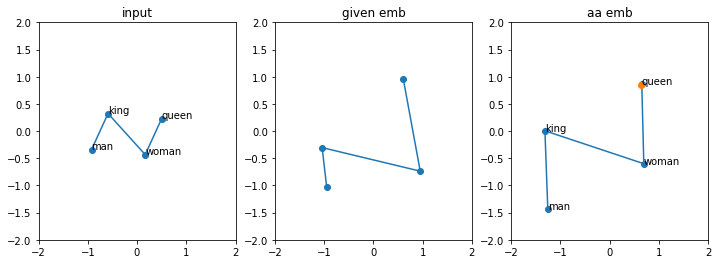

In [258]:
# vectors in input space
labels = ['man', 'king','woman','queen']
vs = 2*torch.rand(4,2, requires_grad=False)-1 # 
vs[3] = vs[1] - vs[0] + vs[2]  # queen = king - man + woman


def inp_to_aa(v):
    with torch.no_grad():
        z0 = given_model.encode(vs.to(device))
        return aa_model.encode(z0),  z0

def aa_to_inp(z):
    with torch.no_grad():
        z0 = aa_model.decode(z.to(device))
        return given_model.decode(z0), z0
    

def plot_math_demo(x, forward=True, labels=[]):  # forward = inputs to z's, backaward = z's to inputs

    if forward:
        vs = x
        zs, z0 = inp_to_aa(x)
        maybe = zs[1] - zs[0] + zs[2]
    else:
        zs = x
        vs, z0 = aa_to_inp(x)
        maybe = vs[1] - vs[0] + vs[2]
        
    [vs, zs, z0, maybe] = [ x.cpu().numpy() for x in [vs, zs, z0, maybe]]

    fig, ax = plt.subplots(1,3,figsize=(12,4))
    for i, s in enumerate(['input','given emb','aa emb']):
        ax[i].set_title(s)
        
    for i, q in enumerate([vs, z0, zs]):
        ax[i].plot(q[:,0], q[:,1], marker='o') 
   
    print("orange dot shows the 'guess'")
    ax[forward*2].plot(maybe[0], maybe[1], marker="o") # and mark the guess with another color
    
    for i,lab in enumerate(labels):
        ax[0].text(vs[i,0],vs[i,1], lab)
        ax[2].text(zs[i,0],zs[i,1], lab)

    points = np.vstack((vs,zs))
    valmin, valmax = 1.1*points.min(axis=0), 1.1*points.max(axis=0)
    for i in range(3):
        ax[i].set_xlim(-2,2)
        ax[i].set_ylim(-2,2)

    plt.plot()
    
plot_math_demo(vs, labels=labels)

### Backward summation

orange dot shows the 'guess'


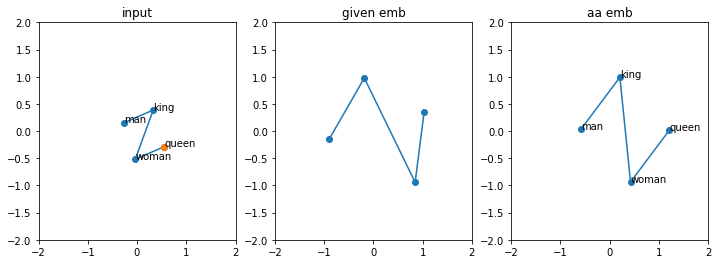

In [247]:
# vectors in input space
zs = 2*torch.rand(4,2, requires_grad=False)-1 # 1 = king, 0=man, 2=woman
zs[3] = zs[1] - zs[0] + zs[2]  # queen = king - man + woman
plot_math_demo(zs, forward=False, labels=labels)

### Demix
Pretend we're mixing 4 stems.  But then we want to remove the last one. 
We can do the math for that in the input space.  But can we also do it in the aa embedding space? 

mix_remove_guitar = tensor([[-0.7619,  0.2311]])
guess =          tensor([[-0.7533,  0.2174]])


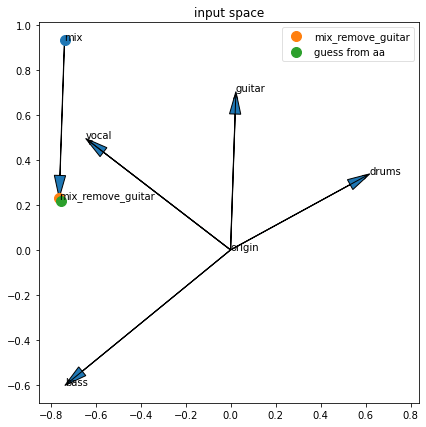

In [171]:
labels = ['guitar','drums','bass','vocal']

i_rm = random.randint(0,len(labels)-1)

# input space
vs = 2*torch.rand(4,2, requires_grad=False) -1
mix = vs.sum(dim=0).unsqueeze(0)
mix_rm = mix - vs[i_rm,:]  # subtract a stem in input space
print(f"mix_remove_{labels[i_rm]} = {mix_rm}")


# do the op in embedding space
with torch.no_grad():
    z0s = given_model.encode(vs.to(device))
    z0mix = given_model.encode(mix.to(device))
    
    zs = aa_model.encode(z0s)
    zmix = aa_model.encode(z0mix)
    
    zmix_rm = zmix - zs[i_rm,:]  # subtract a stem in aa embedding space
    
    z0_rm = aa_model.decode(zmix_rm)
    guess = given_model.decode(z0_rm).cpu()
    print(f"guess =          {guess}")


#plot what we got, in input space 
fig, ax = plt.subplots(figsize=(7,7))

ax.text(0,0 ,f"origin")
for i in range(4):         # plot all the stems and put labels on them 
    ax.arrow(0,0, vs[i,0], vs[i,1], length_includes_head=True, head_width=0.05, head_length=0.1)  # plot vectors for stems
    ax.annotate("", xy=(vs[i,0], vs[i,1]), xytext=(0, 0), arrowprops=dict(arrowstyle="->"))
    ax.text(vs[i,0],vs[i,1],f"{labels[i]}")
    
plt.plot(mix[:,0],mix[:,1], marker='o', markersize=10)  # also plot and label the mix
ax.text(mix[:,0],mix[:,1], "mix")

# connect mix and removed value
dv = mix_rm - mix 
ax.arrow(mix[0][0], mix[0][1], dv[0][0], dv[0][1], length_includes_head=True, head_width=0.05, head_length=0.1)  
ax.annotate("", xy=(vs[i,0], vs[i,1]), xytext=(0, 0), arrowprops=dict(arrowstyle="->"))


ax.plot(mix_rm[:,0],mix_rm[:,1], marker='o', label=f'mix_remove_{labels[i_rm]}', linestyle='None', markersize=10) # plot the point in real space
ax.text(mix_rm[:,0],mix_rm[:,1], f'mix_remove_{labels[i_rm]}')


ax.plot(guess[:,0],guess[:,1], marker='o', label='guess from aa', linestyle='None', markersize=10) # guess = input recon of what was done in aa emb space

plt.axis('square')
ax.set_aspect('equal', adjustable='box')
ax.set_title("input space")
ax.legend(fancybox=True, framealpha=0.6, prop={'size': 10})

If the green dot is covering the orange dot, then it worked! 